In [1]:
import os, sys

if "adroit" in os.uname()[1]:
    CUSTOM_MODULE_PATH = "/home/jylin/thesis/modules"
else:
    CUSTOM_MODULE_PATH = "/System/Volumes/Data/Users/jesselin/Dropbox/src/thesis/modules"
sys.path.append(CUSTOM_MODULE_PATH)

# custom libraries
from entropy import get_entropy
from my_funcs import *

# usual libraries
import glob
from collections import defaultdict
import argparse
import functools
import time
from tqdm import trange, tqdm
from datetime import datetime
import pickle

# scientific libraries
import numpy as np

# ML libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# Global variables we expect to be set by commandline
DATA_DIR = None
RES_DIR = None
MAX_LOOP_VAR = None
TENSORBOARD_LOG_DIRNAME = None
EXP_NUM = None
TRIAL_NUM = None
EXP_DIR = None
OUTPUT_DATA_DIR = None
_DEFAULT_NUM_SAMPLES = 2048


/opt/homebrew/Caskroom/miniforge/base/envs/thesis_arm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# jupyter libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
INTERACTION_Kc = np.log(1+ np.sqrt(2))/2

In [4]:
RES_DIR = "/Users/jesselin/Dropbox/src/thesis/final/resources"
DATA_DIR = "/Users/jesselin/Dropbox/src/thesis/final/data"

In [5]:
def process_data(data_filename: str, interaction_K: list, num_samples: int, batch_size: int = 10, num_workers: int = 0):
    """ Takes filename of .npz files for 1D simulations and returns the DataLoader object """
    dataset = SpinSequenceDataset(data_filename, interaction_K)
    div, mod = divmod(len(dataset), num_samples)

    # make list of the split proportions
    split_list = [num_samples for x in range(div)]
    split_list.append(mod)

    dataset_after_split = random_split(dataset, split_list)
    train_loader = DataLoader(dataset_after_split[0], batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader

def preprocess_data(exp_dir: str):
    """ Stopgap hack to just select the longest iteration file from
    one of the experiment directories for 2D old_data. Returns path of file and interaction_K """
    search_term = os.path.join(exp_dir, "lattice*.txt")
    raw_file_list = glob.glob(search_term)
    data_sample_filepath = raw_file_list[-1]
    f = data_sample_filepath.split("_")
    temperature_index = f.index("T") + 1
    interaction_K = 1/float(f[temperature_index])

    return data_sample_filepath, interaction_K

In [6]:
def make_dataloader(dataset: SpinSequenceDataset, num_samples: int, batch_size: int = 10, num_workers: int = 0):
    """ Takes dataset and returns the DataLoader object """
    div, mod = divmod(len(dataset), num_samples)

    # make list of the split proportions
    split_list = [num_samples for x in range(div)]
    split_list.append(mod)

    dataset_after_split = random_split(dataset, split_list)
    train_loader = DataLoader(dataset_after_split[0], batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader


In [7]:
def get_hdata(model, dataset, num_samples):
    spin_sequence_list = []
    standard_hidden_sequence_list = []
    whh = model.rnn.weight_hh_l0
    iterable_dataset = iter(dataset)
    for sample in trange(num_samples):
        spin_sequence, _ = next(iterable_dataset)
        numpy_spin_sequence = spin_sequence.detach().squeeze().numpy()
        spin_sequence_list.append(numpy_spin_sequence)
        hidden_sequence = model.record_hidden(spin_sequence)
        standard_hidden_sequence = torch.matmul(whh, hidden_sequence.unsqueeze(-1)).detach().squeeze().numpy()
        standard_hidden_sequence_list.append(standard_hidden_sequence)

    return spin_sequence_list, standard_hidden_sequence_list

In [8]:
def get_interaction_K(resource_filepath):
    basename, file_ext = os.path.splitext(os.path.basename(resource_filepath))
    interaction_K_str = basename[basename.index("K=")+2:]
    interaction_K_str = interaction_K_str.strip("[]").replace(",","").split(" ")
    interaction_K = [float(s) for s in interaction_K_str if s != ""]
    return interaction_K

def get_kfrac(log_dir):
    basename = os.path.basename(log_dir)
    idx = basename.index("kfrac=") + len("kfrac=")
    return basename[idx:]

In [9]:
def get_model(kfrac, hidden_size, trial_num):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn/2d_cluster_data/compiled tight nn"
    search_term = "logs_2D*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    model_dir_dict = {round(float(get_K(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    checkpoint_dir = os.path.join(model_dir_dict[kfrac], f"hidden_size={hidden_size}/version_{trial_num}/checkpoints")
    checkpoint_basename, = os.listdir(checkpoint_dir)
    checkpoint = os.path.join(checkpoint_dir, checkpoint_basename)
    return IsingRNN_compat.load_from_checkpoint(checkpoint)

In [10]:
def get_spin_file(kfrac):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn_compiled/test_res_dir/compiled tensors"
    search_term = "compiled*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    spin_file_dict = {round(1/float(get_T(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    return spin_file_dict[kfrac], spin_file_dict

In [11]:
def get_fake_sequence_dataset(input_state_list, list_proportions=None, size=1000) -> zip:
    """ Returns zip of fake sequence, but implements iter so can use in make_dataloader """
    full_tensor = torch.tensor([])

    # find smallest input state
    tmp = [len(i) for i in input_state_list]
    smallest_input_state = input_state_list[np.argmin(tmp)]

    num_repeats = (size // smallest_input_state.shape[-1]) + 1
    for i in range(num_repeats):
        if list_proportions is not None:
            assert np.sum(list_proportions) == 1
            input_state = np.random.choice(input_state_list, p=list_proportions)
        else:
            input_state, = input_state_list
        full_tensor = torch.cat((full_tensor, input_state))

    # crop to size
    full_tensor = full_tensor[:size]

    samples_tensor = torch.empty((1000, size))
    for _ in range(samples_tensor.shape[0]):
        samples_tensor[_] = full_tensor
    fake_dataset = zip(samples_tensor[:,:-1], samples_tensor[:,1:])
    return fake_dataset
def get_state_locations(reduced_hdata, bin_count=20):
    freq, bin_edges = np.histogram(reduced_hdata, bins=bin_count, density=True)
    bin_centers = []
    for i in range(len(bin_edges)-1):
        bc = (bin_edges[i]+bin_edges[i+1])/2
        bin_centers.append(bc)
    freq[freq!=0] = 1
    a = freq*bin_centers
    return sorted(a[a!=0])

nearest_neighbor_bool True
k2_bool False
k3_bool False


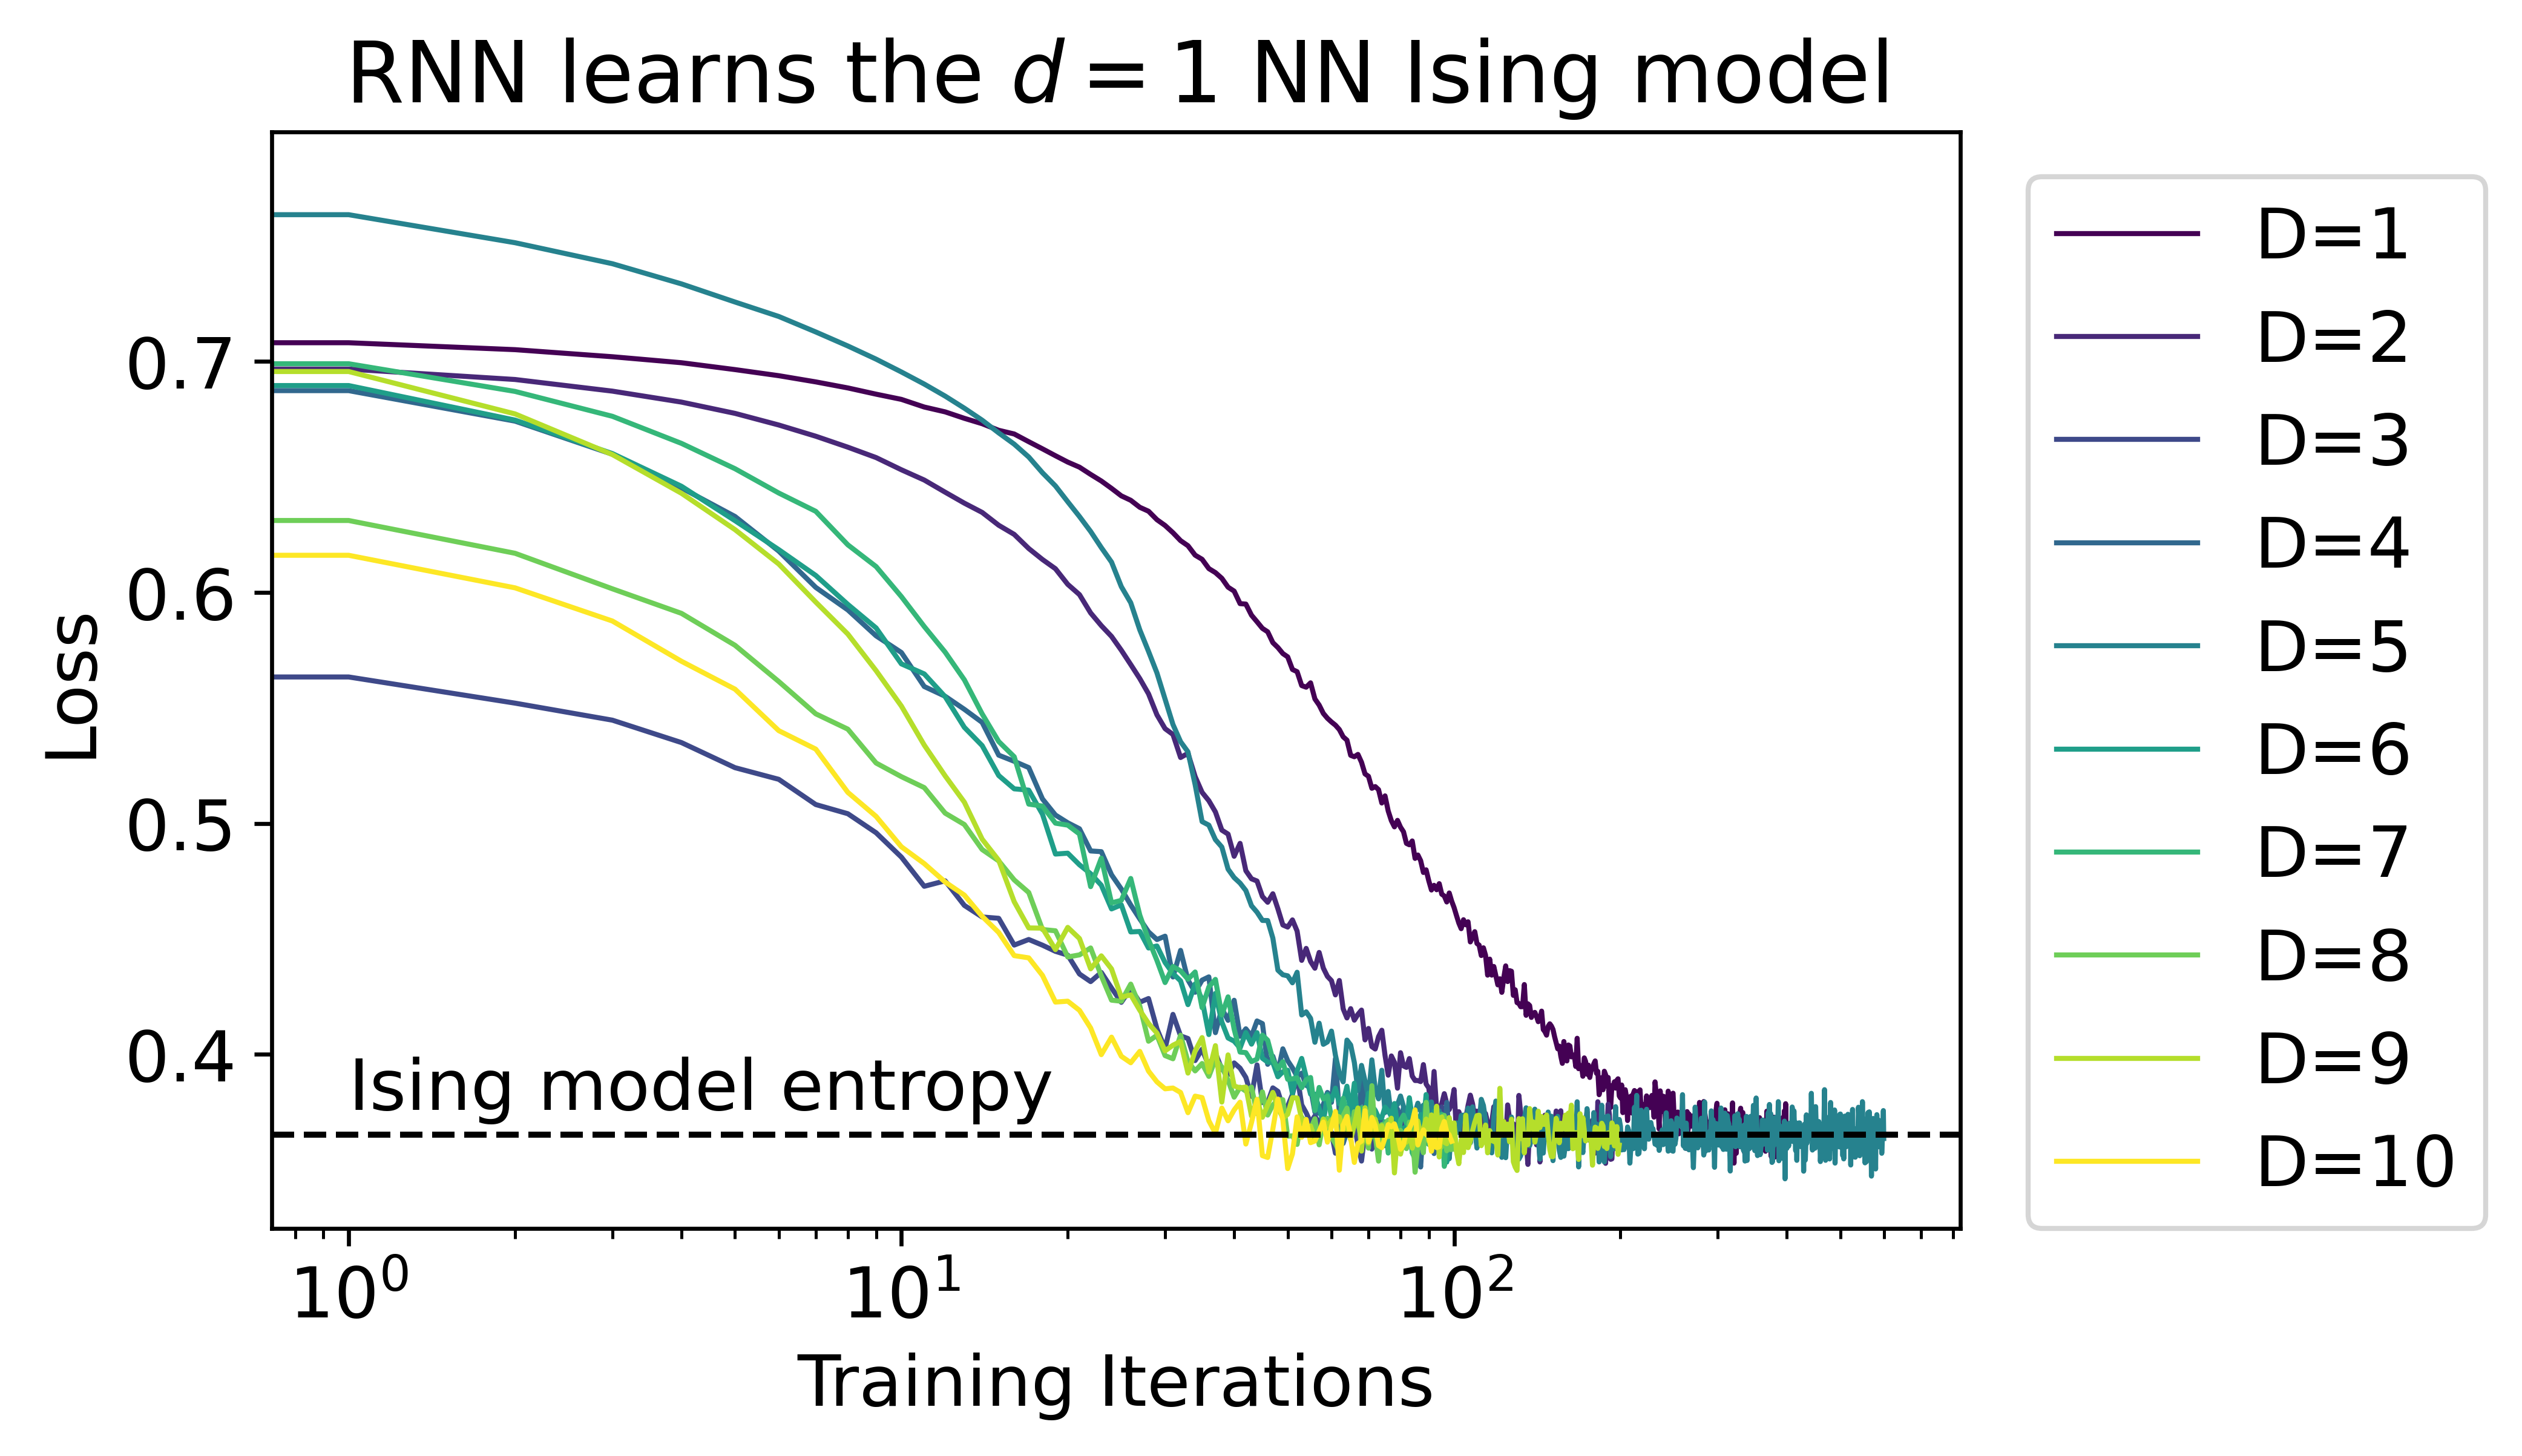

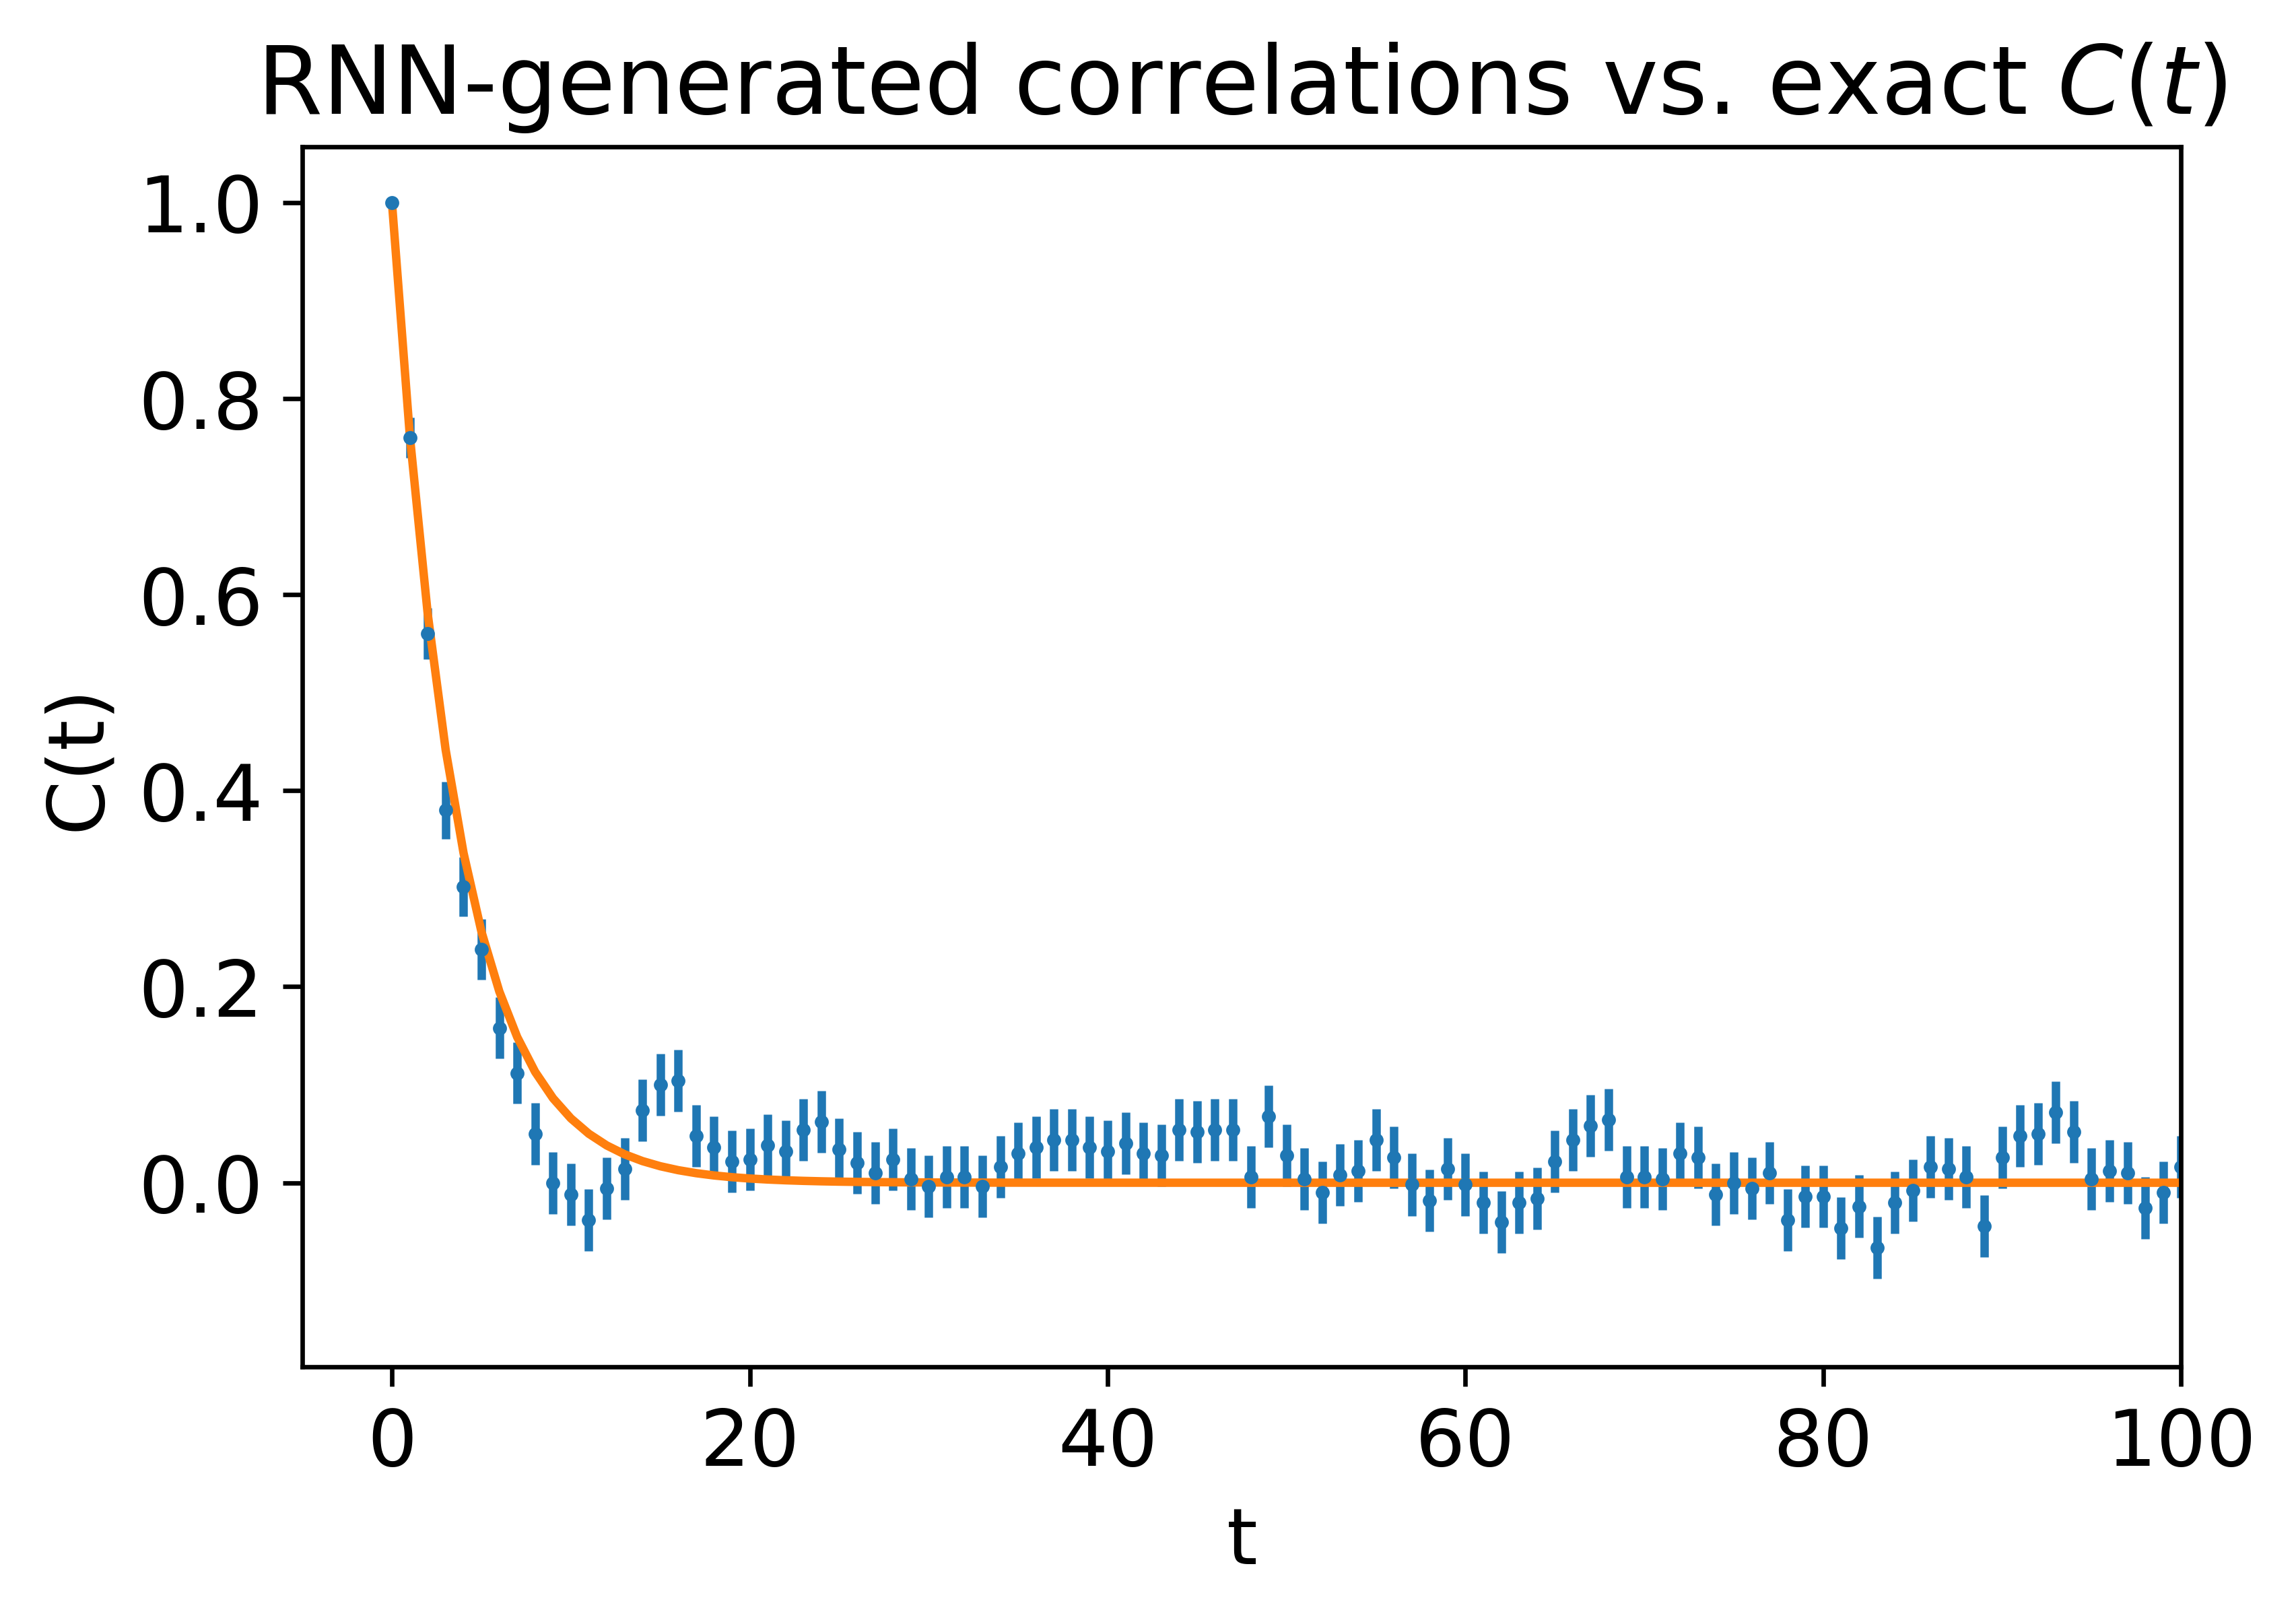

100%|██████████| 1/1 [00:00<00:00, 237.97it/s]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


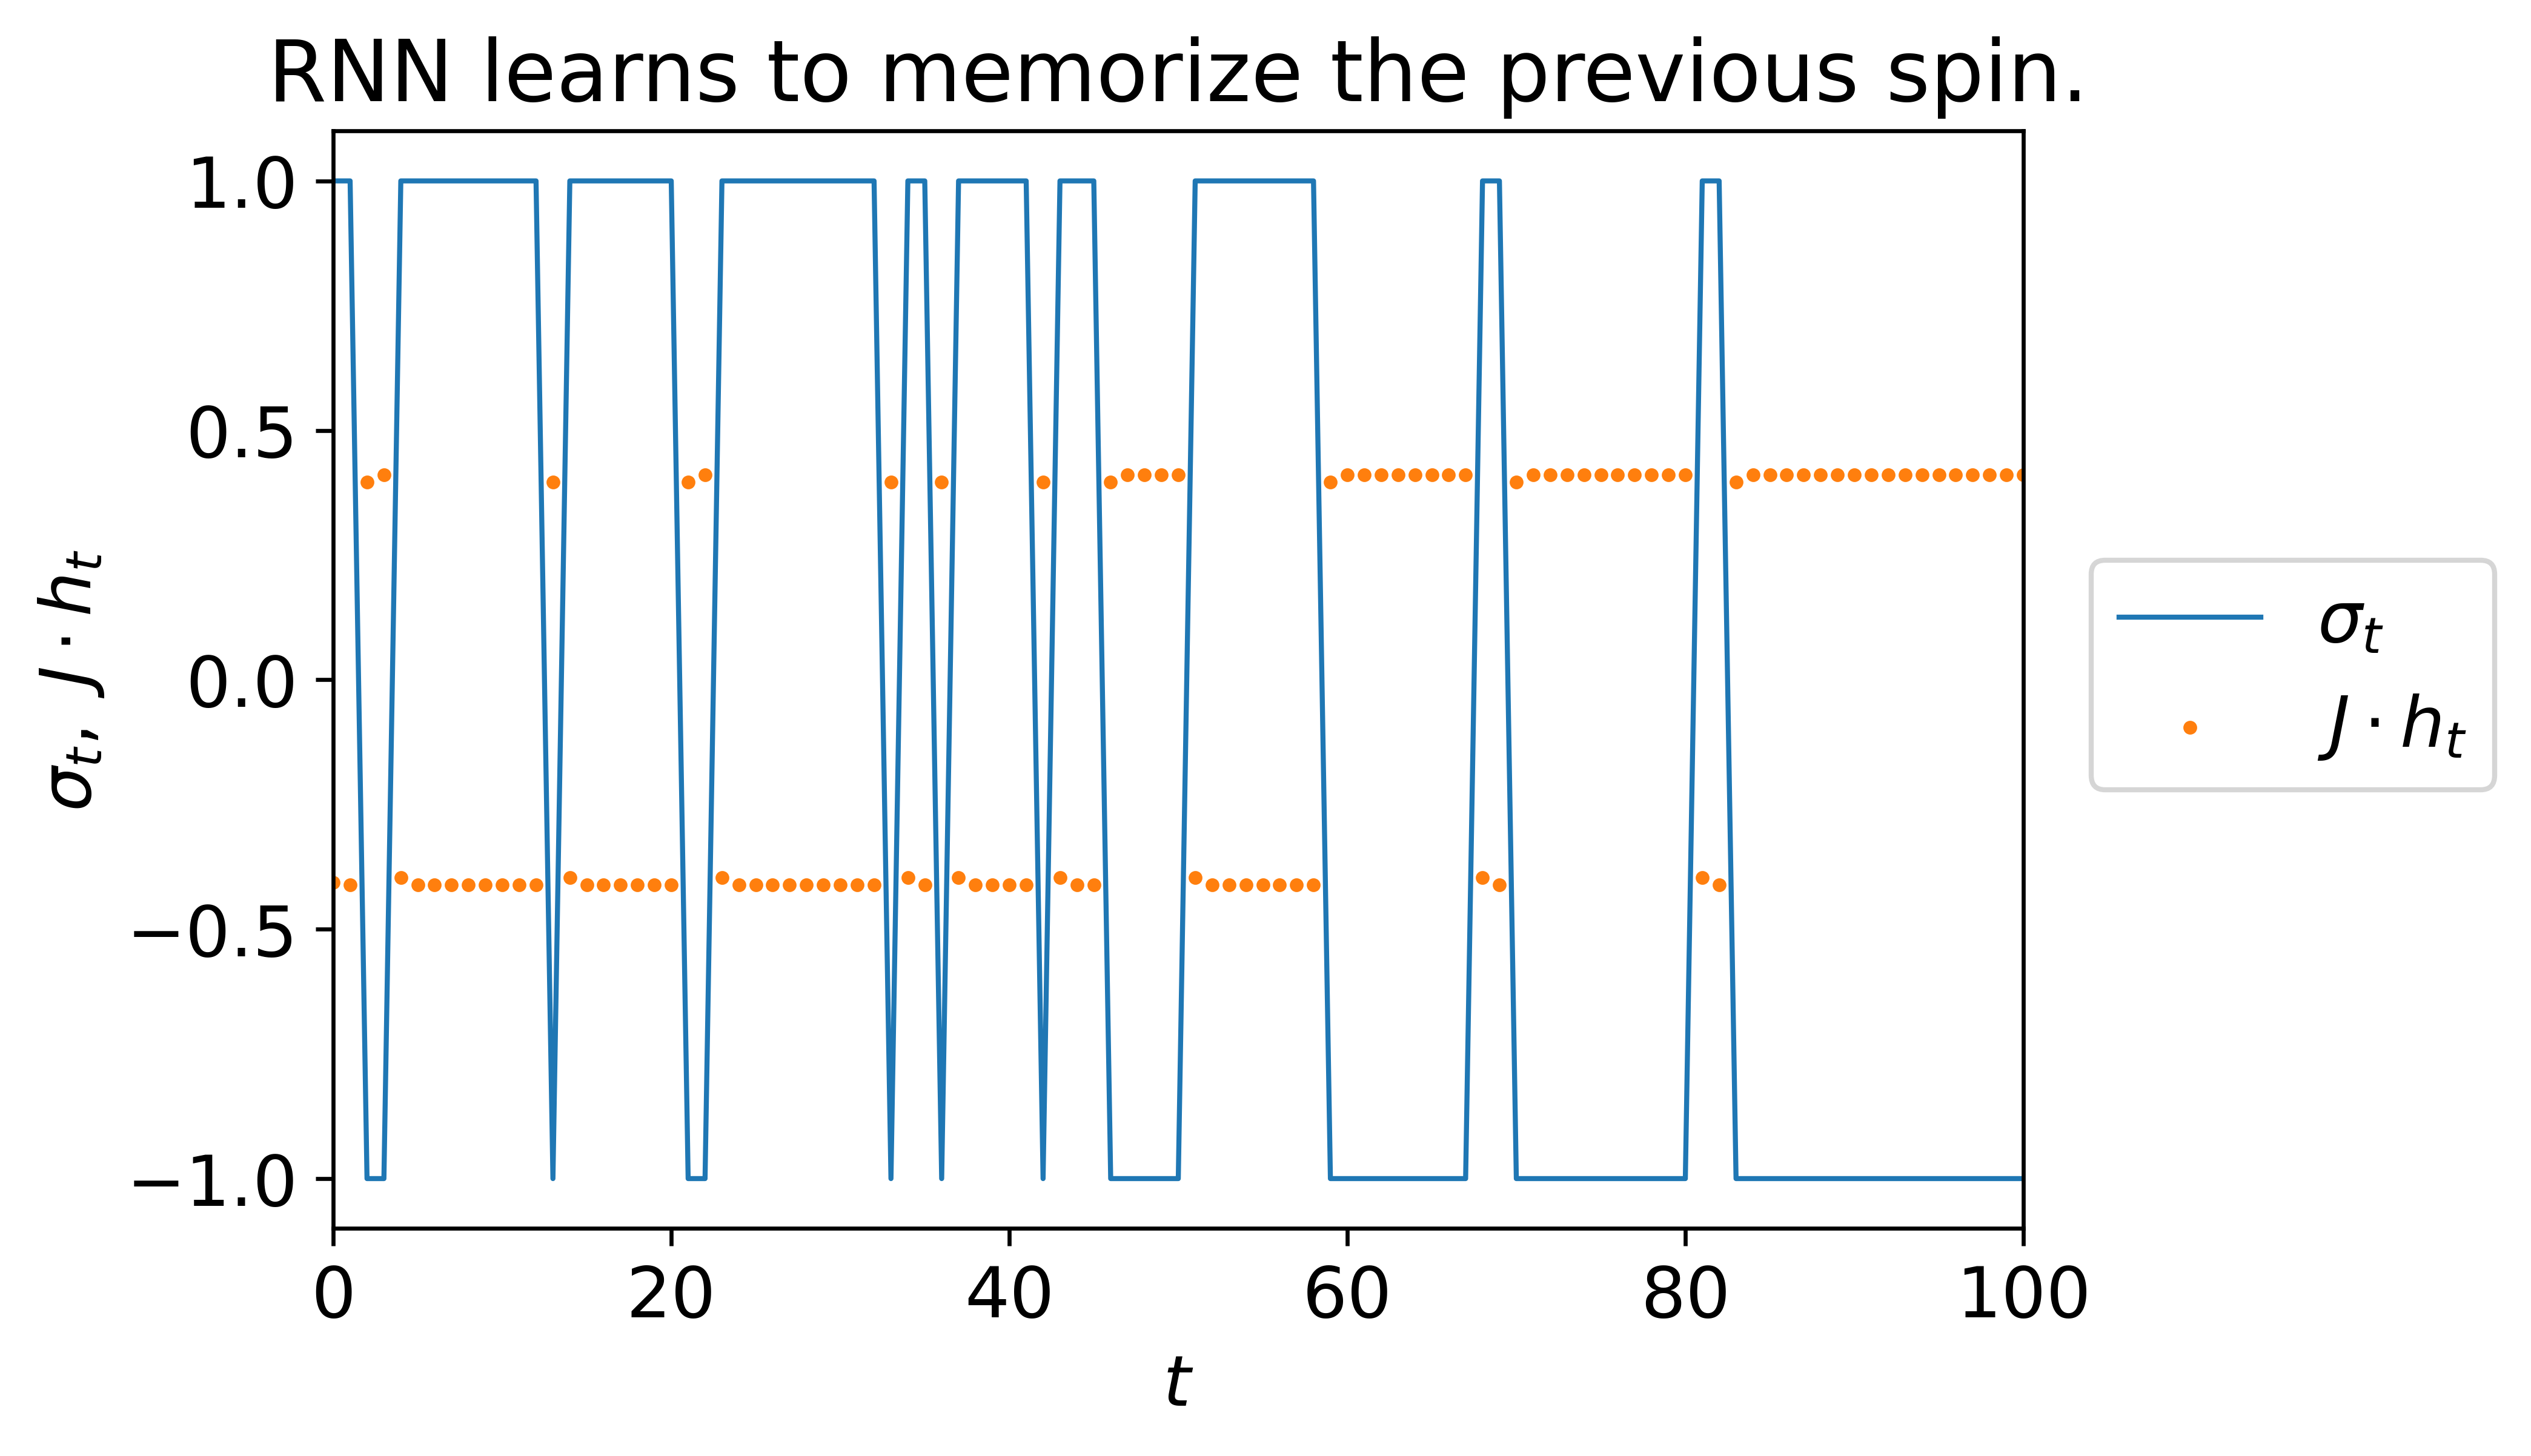

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/macbook_K=[1.0, 0.1]/hidden_size=2/version_0/checkpoints/epoch=99-step=999.ckpt'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/macbook_K=[1.0, 0.1]/hidden_size=2/version_0/checkpoints/epoch=99-step=999.ckpt'

In [14]:
# import the figure drawing code
%run "finalFigures.ipynb"

# 1D

## SR

In [61]:
data_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn/macbook_simple_1D"
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1. 0. 0.].npz", 1)

In [62]:
hidden_size = 1
model = IsingRNN_simple_compat.load_from_checkpoint(f"/Users/jesselin/Dropbox/src/thesis/experiments/rnn/macbook_simple_1D/hidden_size={hidden_size}/version_0/checkpoints/epoch=14-step=374.ckpt")

In [64]:
model.rnn.weight_hh_l0

Parameter containing:
tensor([[0.4281]], requires_grad=True)

In [65]:
model.rnn.weight_ih_l0


Parameter containing:
tensor([[2.1663]], requires_grad=True)

In [66]:
spindata_arr, hdata_arr = get_hdata(model, dataset, 10)

100%|██████████| 10/10 [00:00<00:00, 245.07it/s]


In [67]:
hdata = hdata_arr[0]

In [68]:
spindata, hdata = spindata_arr[0], hdata_arr[0]
if hidden_size == 1:
    reduced_hdata = hdata
else:
    reduced_hdata, evals, _ = pca(hdata, pc_count=1)

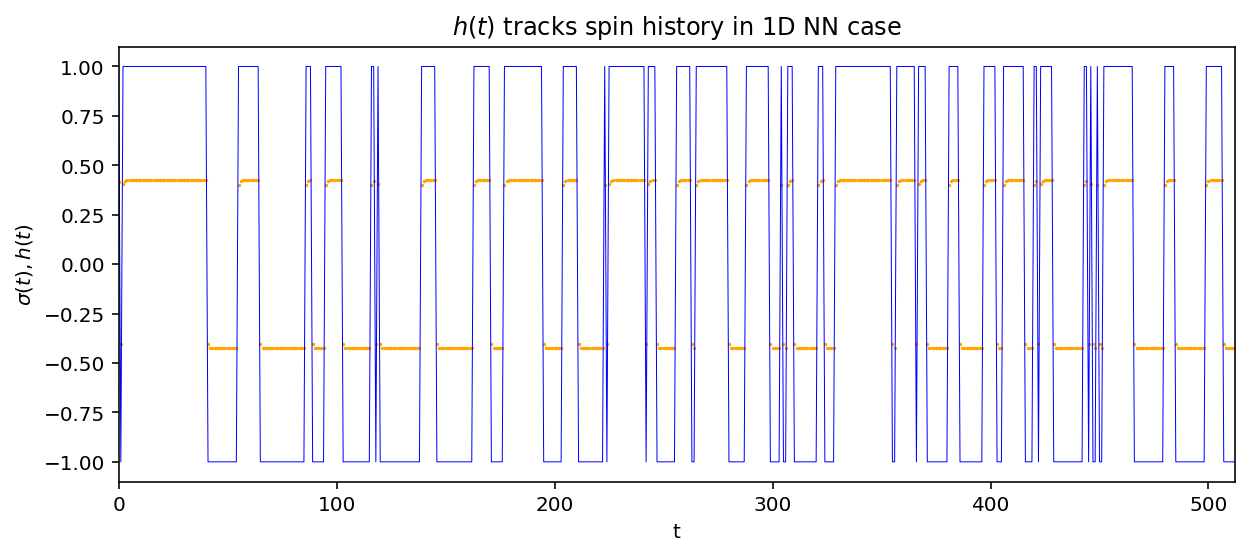

In [69]:
fig = spin_history(spindata, reduced_hdata)

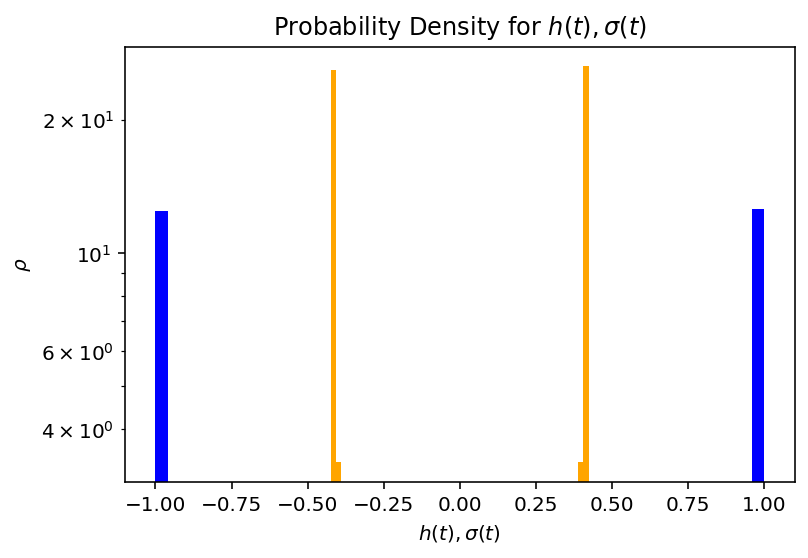

In [70]:
fig = spin_dynamics_histogram(spindata, reduced_hdata)

In [986]:
ghetto_dataset = get_fake_sequence_dataset(torch.tensor([1., -1., 1.]))

In [987]:
spindata_arr, hdata_arr = get_hdata(model, ghetto_dataset, num_samples=1)
spindata, ghetto_hdata = spindata_arr[0], hdata_arr[0]

100%|██████████| 1/1 [00:00<00:00, 240.73it/s]


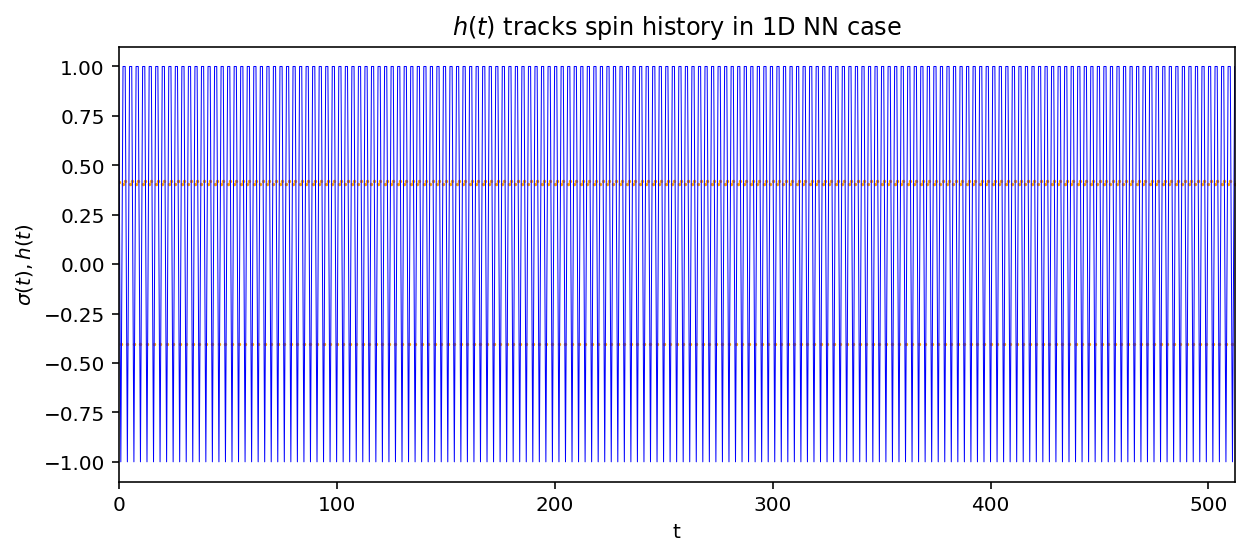

In [988]:
fig = spin_history(spindata, ghetto_hdata)

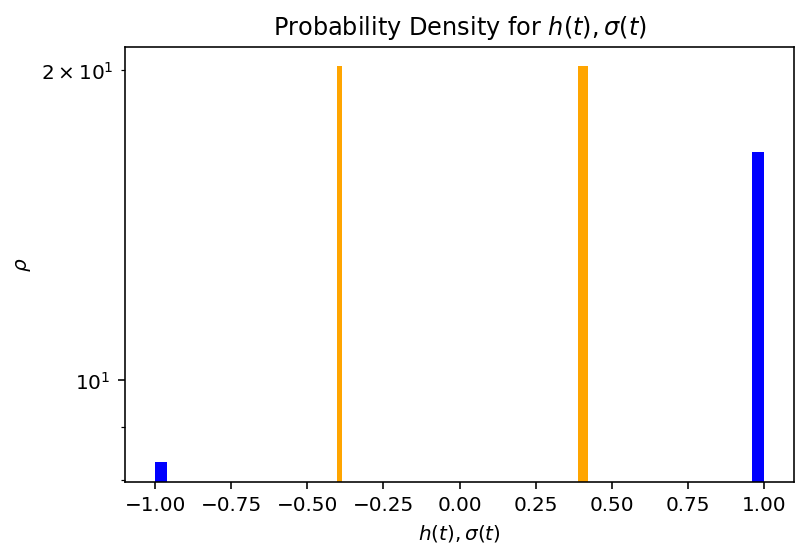

In [989]:
fig = spin_dynamics_histogram(spindata, ghetto_hdata)

### Try low temperature

In [71]:
data = np.load("1dNNMC_K=2.npz")["data"]
K = 2
data = torch.tensor(data)
dataset = SpinSequenceDataset("1dNNMC_K=2.npz", K)

In [72]:
model_low_T = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/SR/macbook_K=2/hidden_size=1/version_0/checkpoints/epoch=12-step=1299.ckpt")

In [73]:
spindata_arr, hdata_arr = get_hdata(model_low_T, dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 235.40it/s]


In [74]:
spindata, hdata = spindata_arr[0], hdata_arr[0]

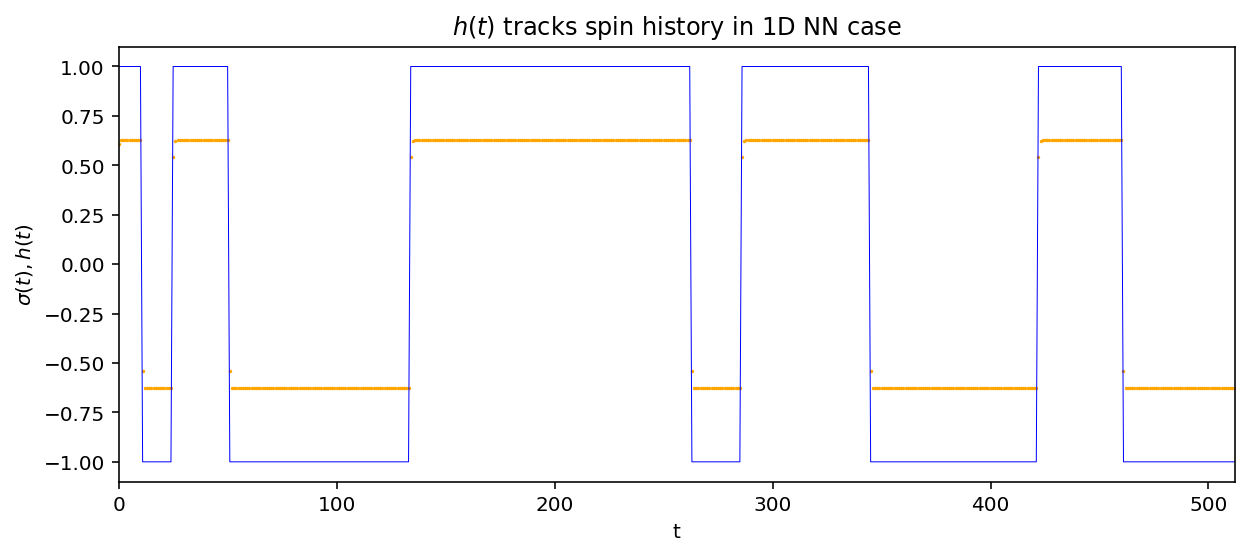

In [75]:
_ = spin_history(spindata, hdata)

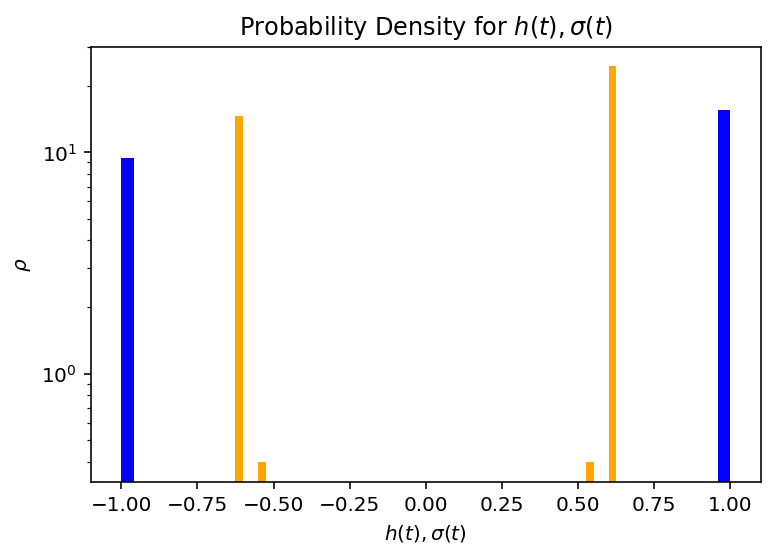

In [76]:
fig, spinhist, hhist = spin_dynamics_histogram(spindata, hdata)

In [77]:
ghetto_dataset = get_fake_sequence_dataset([torch.tensor([1.,-1.]), torch.tensor([1.,1.]), torch.tensor([-1.,-1.]), torch.tensor([-1., 1.])], [0, 0, 0, 1])

NameError: name 'get_fake_sequence_dataset' is not defined

In [1162]:
spindata_arr, hdata_arr = get_hdata(model_low_T, ghetto_dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 200.32it/s]


In [1163]:
spindata, ghetto_hdata = spindata_arr[0], hdata_arr[0]

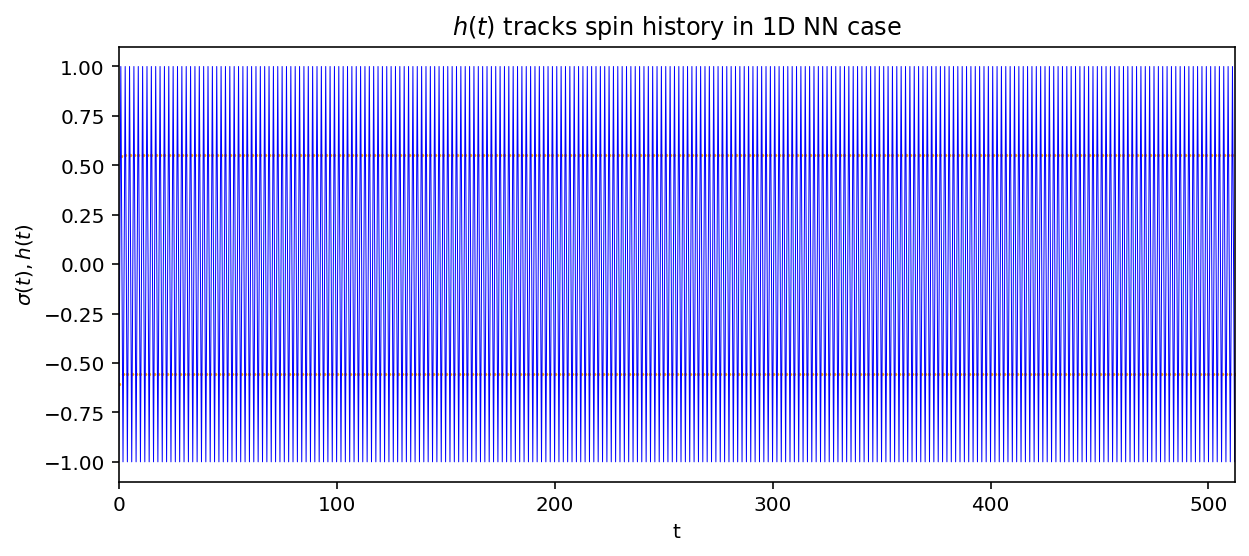

In [1164]:
_ = spin_history(spindata, ghetto_hdata)

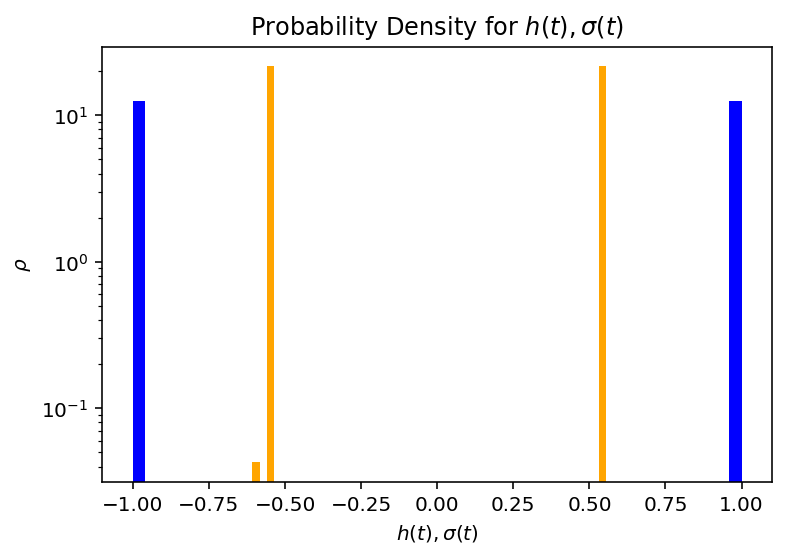

In [1165]:
fig, spinhist, hhist = spin_dynamics_histogram(spindata, ghetto_hdata)

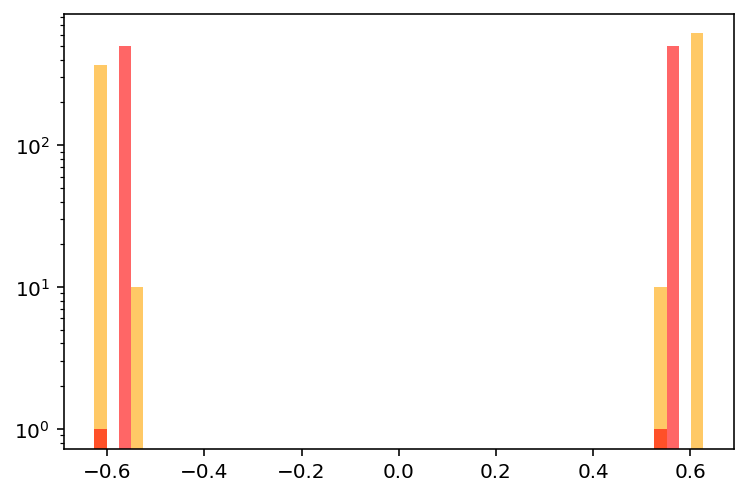

In [1166]:
_, bin1, _ = plt.hist(hdata, bins=50, alpha=0.6, color="orange")
_ = plt.hist(ghetto_hdata, bins=bin1, alpha=0.6, color="red")
plt.yscale("log")

## LR

In [1083]:
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.7].npz", 1)
loaded_model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.7]/hidden_size=1/version_0/checkpoints/epoch=99-step=999.ckpt")

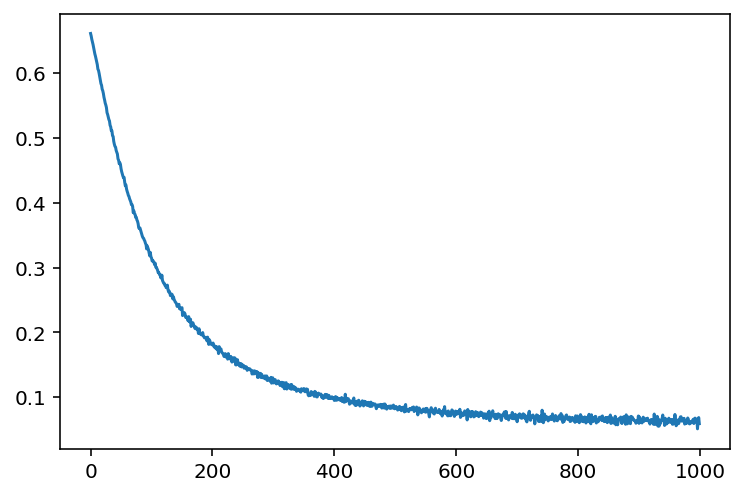

In [1084]:
plt.plot(loaded_model.loss_history)

In [1085]:
spindata_arr, hdata_arr = get_hdata(loaded_model, dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 153.37it/s]


In [1086]:
spindata, hdata = spindata_arr[0], hdata_arr[0]

In [1087]:
reduced_hdata = hdata
#reduced_hdata = reduced_hdata/np.max(reduced_hdata)*0.8

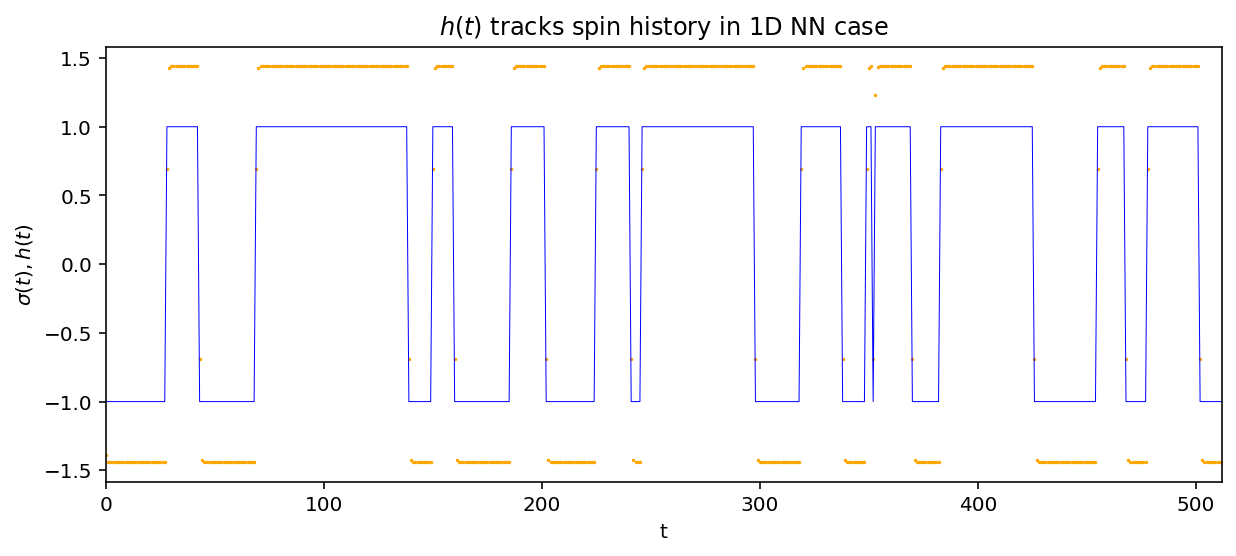

In [1088]:
fig = spin_history(spindata, reduced_hdata)

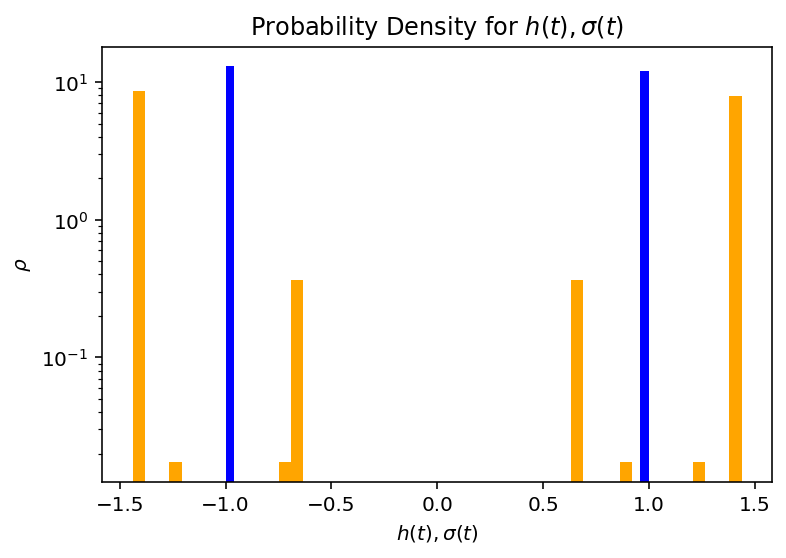

In [1089]:
fig = spin_dynamics_histogram(spindata, reduced_hdata)
plt.yscale("log")

In [1120]:
ghetto_dataset = get_fake_sequence_dataset([torch.tensor([1.,-1.]), torch.tensor([1.,1.]), torch.tensor([-1.,-1.])], [0., 0.0, 1.00])

/var/folders/ty/x496zbwx57z88dn9jdvtm8ww0000gn/T/ipykernel_61265/2059497780.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  input_state = np.random.choice(input_state_list, p=list_proportions)
/var/folders/ty/x496zbwx57z88dn9jdvtm8ww0000gn/T/ipykernel_61265/2059497780.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_state = np.random.choice(input_stat

In [1121]:
spindata_arr, hdata_arr = get_hdata(loaded_model, ghetto_dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 130.48it/s]


In [1122]:
spindata, ghetto_hdata = spindata_arr[0], hdata_arr[0]

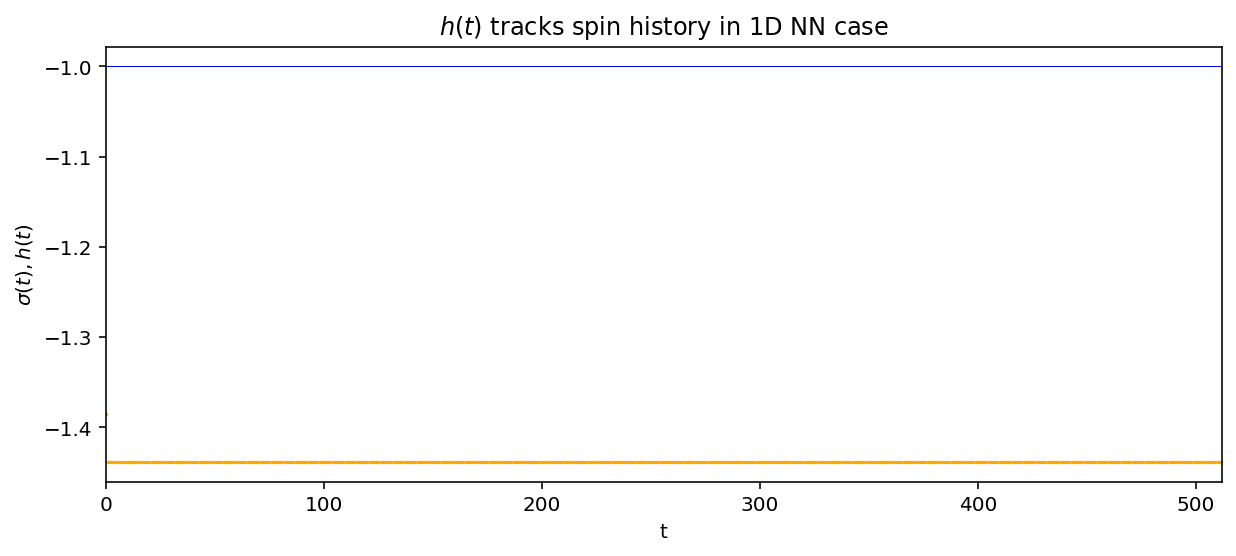

In [1123]:
fig = spin_history(spindata, ghetto_hdata)

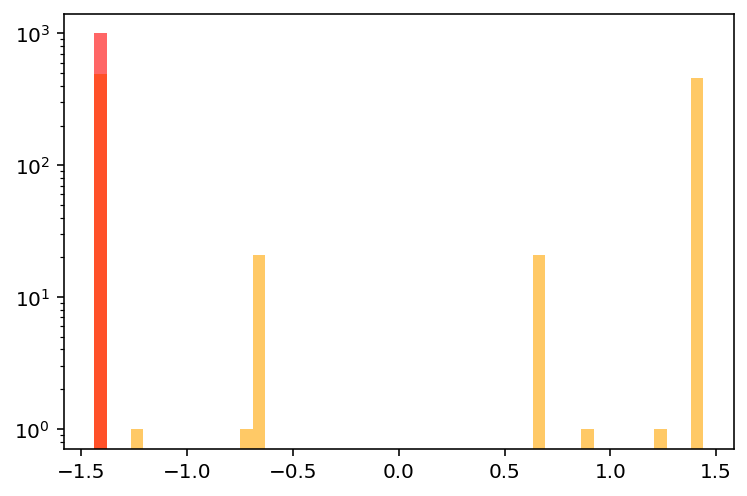

In [1124]:
_, bin1, _ = plt.hist(reduced_hdata, bins=50, alpha=0.6, color="orange")
_, bin2, _ = plt.hist(ghetto_hdata, bins=bin1, alpha=0.6, color="red")
plt.yscale("log")

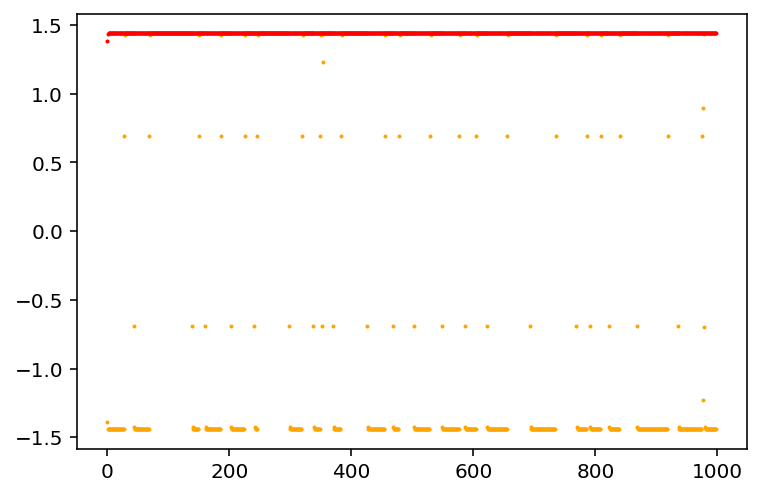

In [1031]:
plt.scatter(range(999), hdata, s=1, c="orange")
plt.scatter(range(999), ghetto_hdata, s=1, c="red")

In [1015]:
res_dir = os.path.join(RES_DIR, "1D/LR")
search_term = "arr_sampledata*"
raw_file_list = glob.glob(os.path.join(res_dir, search_term))

data_dir = os.path.join(DATA_DIR, "1D/LR")

## Testing 4-state transfer matrix

In [1232]:
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.6].npz", 1)
model_dict = {}
for hidden_size in np.arange(5)+1:
    loaded_model = IsingRNN_simple.load_from_checkpoint(f"/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.6]/hidden_size={hidden_size}/version_0/checkpoints/epoch=99-step=999.ckpt")
    model_dict[hidden_size] = loaded_model

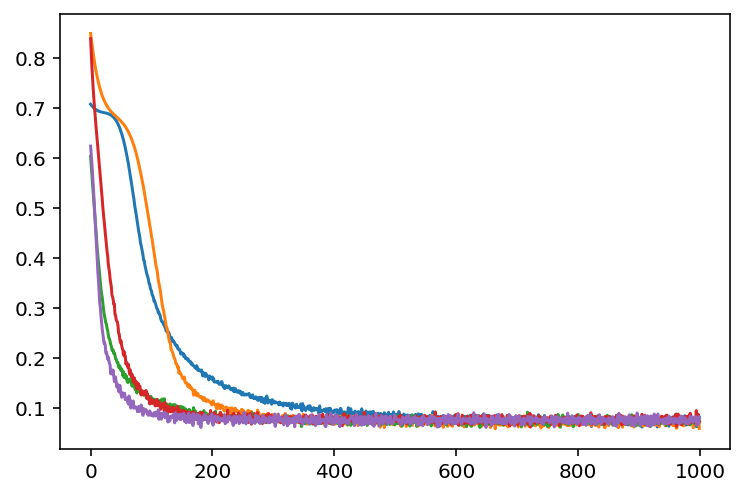

In [1233]:
for m in model_dict.values():
    plt.plot(m.loss_history)

In [1241]:
model = model_dict[1]

In [1275]:
model = IsingRNN_simple.load_from_checkpoint(f"/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.1]/hidden_size=1/version_0/checkpoints/epoch=99-step=999.ckpt")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.6].npz", 1)

In [1276]:
initial_conds = [(-1, -1), (-1,1), (1,-1), (1,1)]
initial_conds = [torch.FloatTensor(x).reshape(1, -1, 1) for x in initial_conds]

In [1277]:
result_dict = {}
for x in initial_conds:
    with torch.no_grad():
        a = model.forward(x)
    prob_arr = a
    probs = torch.exp(a[0][0,1])
    result_dict[x.squeeze()] = probs


In [1278]:
result_dict

{tensor([-1., -1.]): tensor([0.9129, 0.0871], dtype=torch.float64),
 tensor([-1.,  1.]): tensor([0.1192, 0.8808], dtype=torch.float64),
 tensor([ 1., -1.]): tensor([0.8808, 0.1192], dtype=torch.float64),
 tensor([1., 1.]): tensor([0.0871, 0.9129], dtype=torch.float64)}

### Entropy

In [81]:
import sympy
from sympy.parsing.mathematica import mathematica

In [82]:
k1, k2 = sympy.var("k1 k2")
expr = "((-2*E^(2*k2)*(-1 + E^(2*k1))*k1)/Sqrt[4*E^(2*k1) + E^(4*k2)*(-1 + \
E^(2*k1))^2] + (8*E^(k1 + 2*k2)*k2*Cosh[k1])/((-1 + \
E^(4*k2))*Sqrt[4*E^(2*k1) + E^(4*k2)*(-1 + E^(2*k1))^2]) - \
2*k2*1/Tanh[2*k2] - Log[2] + Log[(2*E^(2*k1) + E^(4*k2) + E^(4*(k1 + \
k2)) + E^(2*k2)*(1 + E^(2*k1))*Sqrt[4*E^(2*k1) + E^(4*k2)*(-1 + \
E^(2*k1))^2])/E^(2*(k1 + k2))])/2"
parse_expr = mathematica(expr)
S_NNN = sympy.lambdify([k1,k2], parse_expr)

In [83]:
S_NNN(0.6, 0.2)

0.42560406272349344

Text(0, 0.5, 'Iterations')

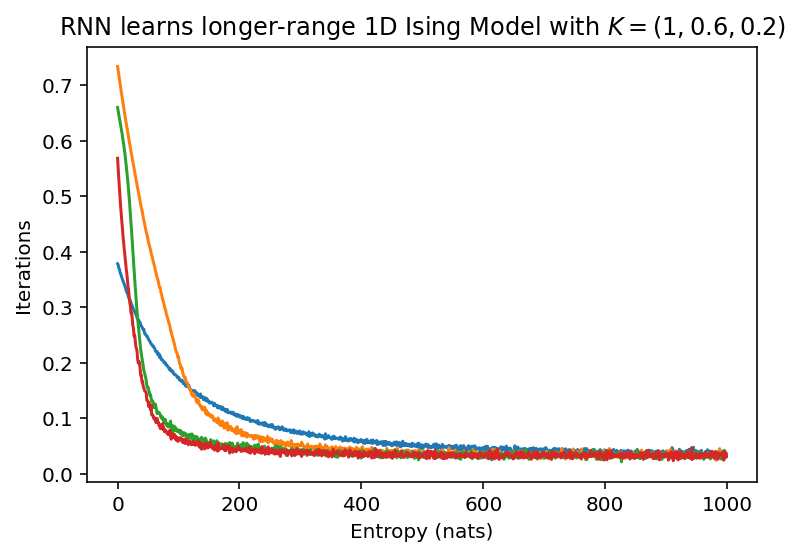

In [1231]:
for hidden_size in np.arange(4)+1:
    loaded_model = IsingRNN_simple.load_from_checkpoint(f"/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/macbook_K=[1.0, 0.6, 0.2]/hidden_size={hidden_size}/version_0/checkpoints/epoch=99-step=999.ckpt")
    plt.plot(loaded_model.loss_history, label=f"D={hidden_size}")
plt.title(r"RNN learns longer-range 1D Ising Model with $K = (1, 0.6, 0.2)$")
plt.xlabel("Entropy (nats)")
plt.ylabel("Iterations")

### $k=2$ state space

In [12]:
def update_rule(h, th, j, hstates):
    j = j.detach().numpy()
    th = th.detach().numpy()
    transition_rules = {}
    for s in [-1, 1]:
        out_state = j*np.tanh(j*h + th*s)
        out_state = out_state.item()
        out_hstate = np.argmin(np.abs(out_state - np.array(hstates)))
        transition_rules[s] = (out_hstate, out_state)
    return transition_rules

In [13]:
def update_rule_2state(h1, th, j, hstates):
    initial_conds = np.array([[-1.,-1.], [-1., 1.], [1., -1.], [1.,1.]])
    j = j.detach().numpy()
    th = th.detach().numpy()
    transition_rules = {}
    for s2 in initial_conds:
        h2 = np.tanh(j*h1 + th*s2[0])
        h3 = np.tanh(j*h2 + th*s2[1])
        out_state = (j*h3).item()
        out_hstate = np.argmin(np.abs(out_state - np.array(hstates)))
        transition_rules[tuple(s2)] = (out_hstate, out_state)
    return transition_rules

In [14]:
def check_transitions(model, hdata, resolution=50):
    with torch.no_grad():
        j = model.rnn.weight_hh_l0
        th = model.rnn.weight_ih_l0

    hstates = get_state_locations(hdata, resolution)
    tr_rules = []
    for h in hstates:
        tr_1s = update_rule(h, th, j, hstates)
        tr_2s = update_rule_2state(h, th, j, hstates)
        tr_rules.append((tr_1s, tr_2s))
    return tr_rules


In [15]:
hidden_size = 1
interaction_K = [1.0, 0.1, 0.0]
data_dir = os.path.join(DATA_DIR, "1D/LR")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.1].npz", interaction_K=interaction_K)
dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

trial = 0
for trial in np.arange(9)+1:
    ckpt_dir = os.path.join(data_dir, f"macbook_K={str(interaction_K)}/hidden_size={hidden_size}/version_{trial}/checkpoints")
    ckpt, = os.listdir(ckpt_dir)
    ckpt_filepath = os.path.join(ckpt_dir, ckpt)

    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    s, h = get_hdata(model, dataloader, 1)
    spindata, hdata = s[0], h[0]


100%|██████████| 1/1 [00:00<00:00, 286.36it/s]


In [19]:
hidden_size = 1
interaction_K = [1.0, 0.1, 0.0]
data_dir = os.path.join(DATA_DIR, "1D/LR")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.1].npz", interaction_K=interaction_K)
dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

trial = 4
ckpt_dir = os.path.join(data_dir, f"macbook_K={str(interaction_K)}/hidden_size={hidden_size}/version_{trial}/checkpoints")
ckpt, = os.listdir(ckpt_dir)

ckpt_filepath = os.path.join(ckpt_dir, ckpt)
model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
s, h = get_hdata(model, dataloader, 1)
spindata, hdata = s[0], h[0]
data = check_transitions(model, hdata, resolution=30)

100%|██████████| 1/1 [00:00<00:00, 111.49it/s]


In [ ]:
hidden_size = 1
interaction_K = [2.0, 0.0, 0.0]
data_dir = os.path.join(DATA_DIR, "1D/SR")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/scripts/1dNNMC_K=2.npz", interaction_K=interaction_K)
dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

trial = 1
ckpt_dir = os.path.join(data_dir, f"macbook_K=2/hidden_size={hidden_size}/version_{trial}/checkpoints")
ckpt, = os.listdir(ckpt_dir)

ckpt_filepath = os.path.join(ckpt_dir, ckpt)
model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
s, h = get_hdata(model, dataloader, 1)
spindata, hdata = s[0], h[0]
data = check_transitions(model, hdata, resolution=30)

In [43]:
hidden_size = 1
interaction_K = [1.0, 0.0, 0.0]
data_dir = os.path.join(DATA_DIR, "1D/SR")
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/scripts/1dNNMC_K=2.npz", interaction_K=interaction_K)
dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

trial = 1
ckpt_dir = os.path.join(data_dir, f"macbook_K=2/hidden_size={hidden_size}/version_{trial}/checkpoints")
ckpt, = os.listdir(ckpt_dir)

ckpt_filepath = os.path.join(ckpt_dir, ckpt)
model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
s, h = get_hdata(model, dataloader, 1)
spindata, hdata = s[0], h[0]
data = check_transitions(model, hdata, resolution=30)

100%|██████████| 1/1 [00:00<00:00, 227.79it/s]


In [244]:
spindata, hdata = spindata_arr[0], hdata_arr[0]
if hidden_size == 1:
    reduced_hdata = hdata
else:
    reduced_hdata, evals, _ = pca(hdata, pc_count=1)
#reduced_hdata = reduced_hdata/np.max(reduced_hdata)*0.8

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        , 203.06399645],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.   

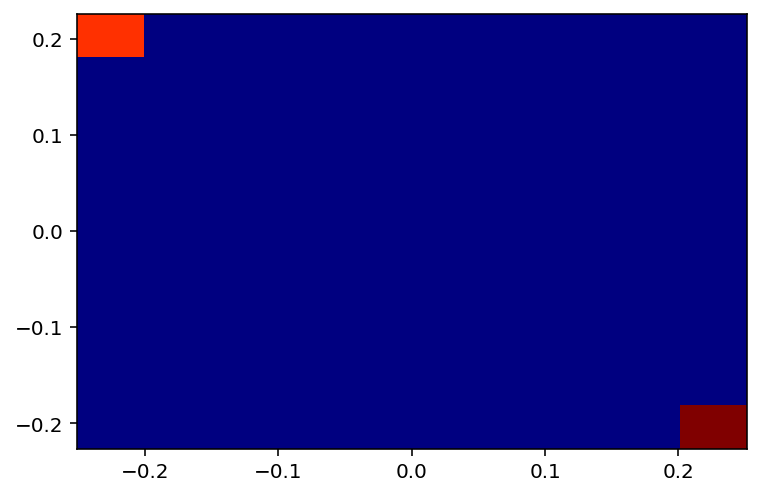

In [245]:
plt.hist2d(hdata[:,0], hdata[:,1], bins=10, density=True, cmap=plt.cm.jet)

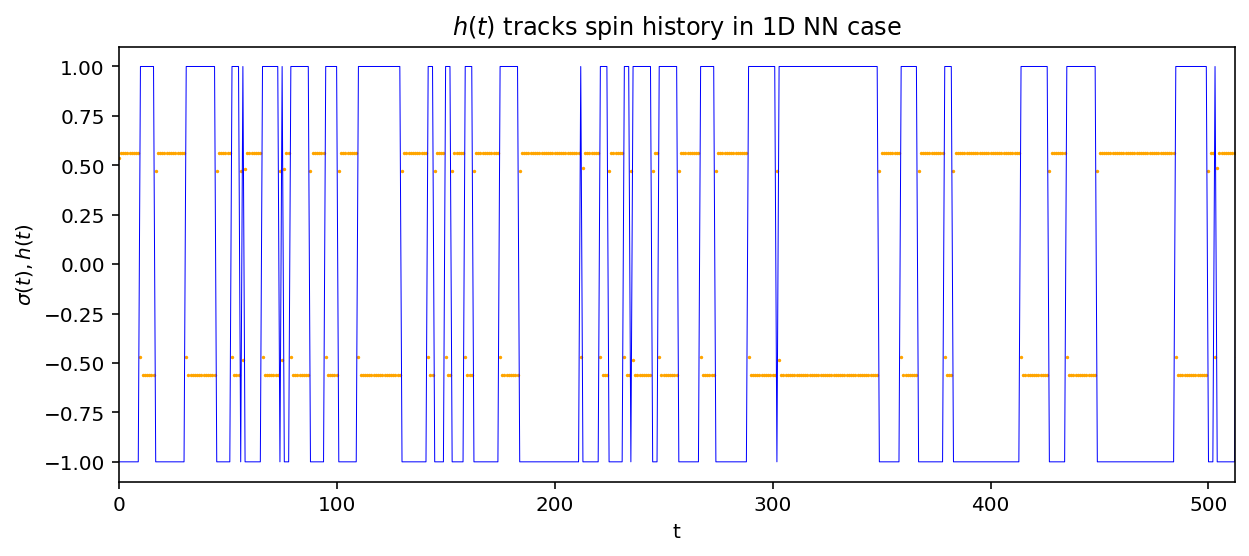

In [136]:
fig = spin_history(spindata, reduced_hdata)

In [112]:
j = model.rnn.weight_hh_l0
th = model.rnn.weight_ih_l0

In [113]:
hstates = get_state_locations(hdata, 30)

In [178]:
update_rule_2state(hstates[3], th, j, hstates)

{(-1.0, -1.0): (3, 0.5630486607551575),
 (-1.0, 1.0): (1, -0.4707210659980774),
 (1.0, -1.0): (2, 0.4793124198913574),
 (1.0, 1.0): (0, -0.5618483424186707)}

In [225]:
data = np.load("1dNNMC_K=2.npz")["data"]
K = 2
data = torch.tensor(data)
dataset = SpinSequenceDataset("1dNNMC_K=2.npz", K)

In [233]:
model_low_T = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/SR/macbook_K=2/hidden_size=2/version_0/checkpoints/epoch=29-step=2999.ckpt")
th = model_low_T.rnn.weight_ih_l0
j = model_low_T.rnn.weight_hh_l0

In [234]:
spindata_arr, hdata_arr = get_hdata(model_low_T, dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 290.79it/s]


In [235]:
spindata, hdata = spindata_arr[0], hdata_arr[0]

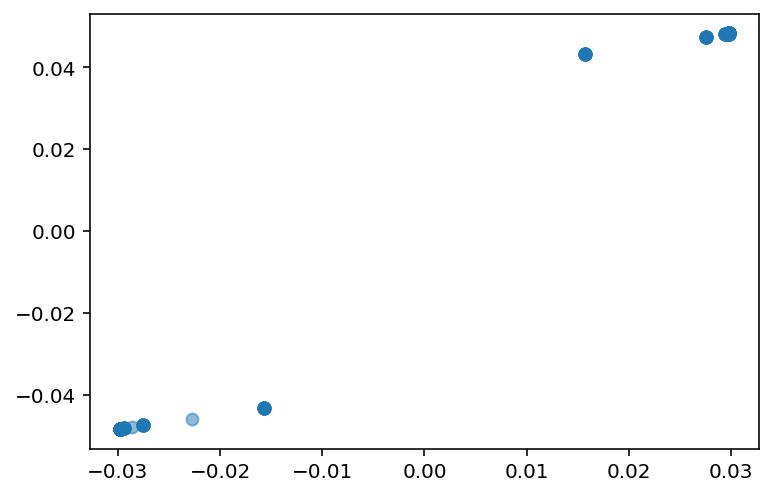

In [238]:
plt.scatter(hdata[:,0], hdata[:,1], alpha=0.5)

(array([[10635.40245921,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ],
        [   17.40655067,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ],
        [  174.0655067 ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        ,    

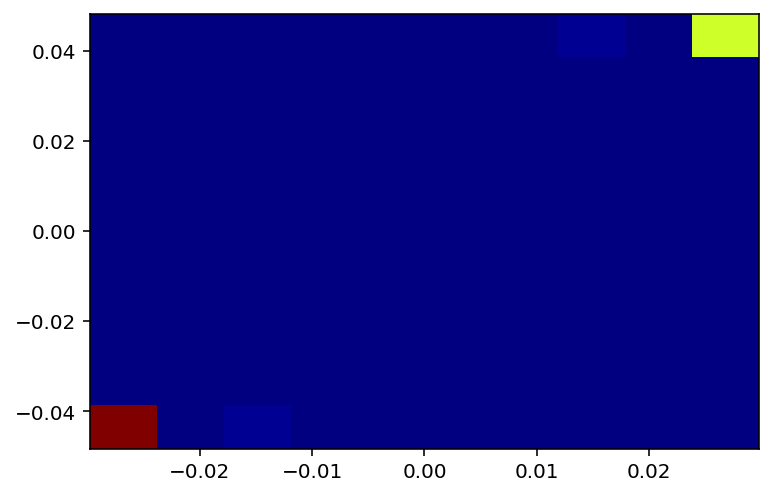

In [240]:
plt.hist2d(hdata[:,0], hdata[:,1], bins=10, density=True, cmap=plt.cm.jet)

In [199]:
update_rule(hstates[3], th, j, hstates)

{-1: (0, -0.5806593894958496), 1: (3, 0.6206440329551697)}

Text(0.5, 1.0, '$h(t)$ for 1D K = (1, 0.1)')

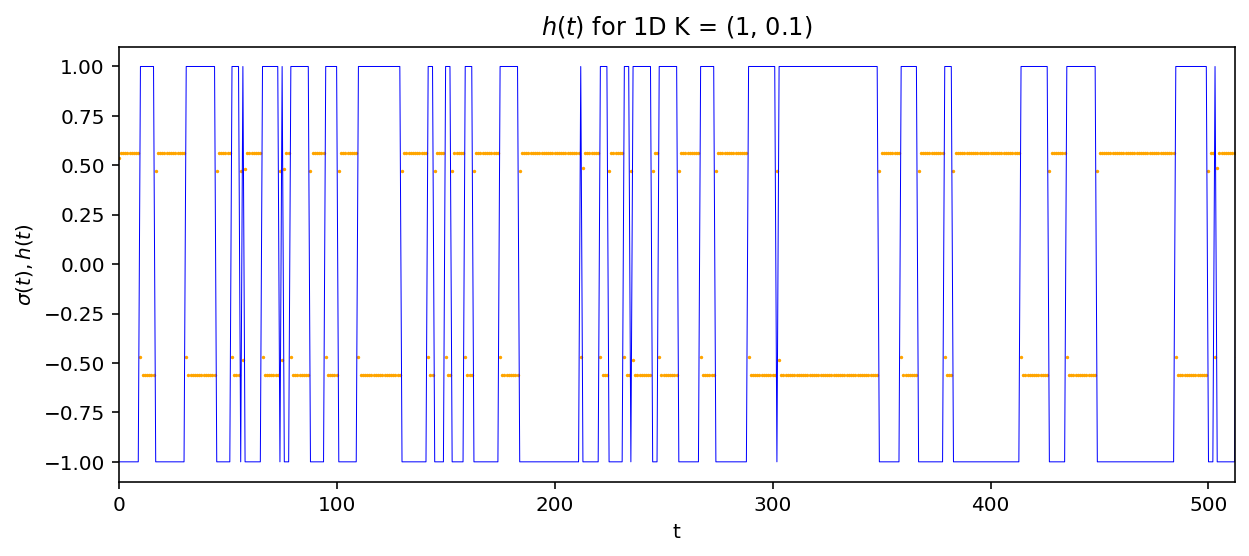

In [93]:
plt.figure(figsize=(10,4))
xdata = np.arange(len(reduced_hdata))
plt.plot(xdata, spindata, linewidth=0.5,c="blue")
plt.scatter(xdata, reduced_hdata, s=0.5,c="orange")
plt.xlim([0,512])
plt.ylabel(r"$\sigma(t), h(t)$")
plt.xlabel(r"t")
plt.title(r"$h(t)$ for 1D K = (1, 0.1)")

Text(0, 0.5, '$\\rho$')

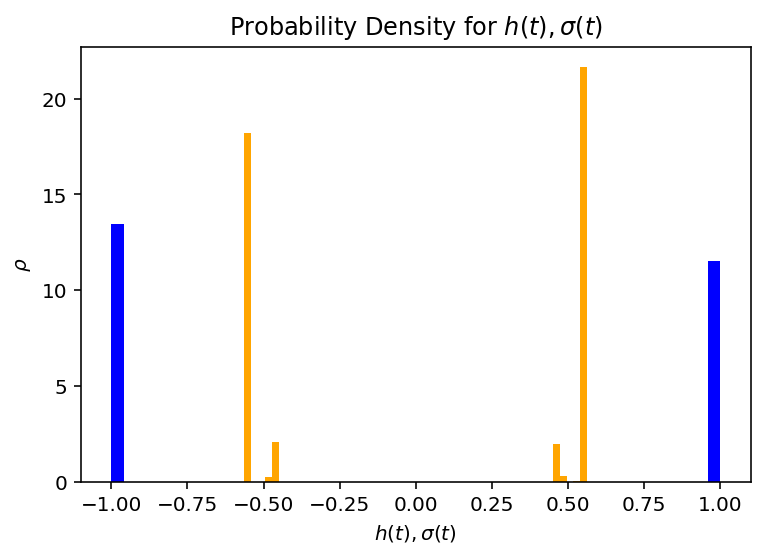

In [94]:
bin_count = 50
hist_spindata = plt.hist(spindata, bins=bin_count, density=True, color="blue")
hist_hdata = plt.hist(reduced_hdata, bins=bin_count, density=True, color="orange")
plt.title(r"Probability Density for $h(t), \sigma(t)$")
plt.xlabel(r"$h(t),\sigma(t)$")
plt.ylabel(r"$\rho$")

## $k=3$ state space?

In [247]:
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.7 0.2].npz", interaction_K=[1, 0.1])

In [248]:
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.7, 0.2]/hidden_size=1/version_0/checkpoints/epoch=99-step=999.ckpt")

In [249]:
spindata_arr, hdata_arr = get_hdata(model, dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 79.08it/s]


In [251]:
spindata, hdata = spindata_arr[0], hdata_arr[0]

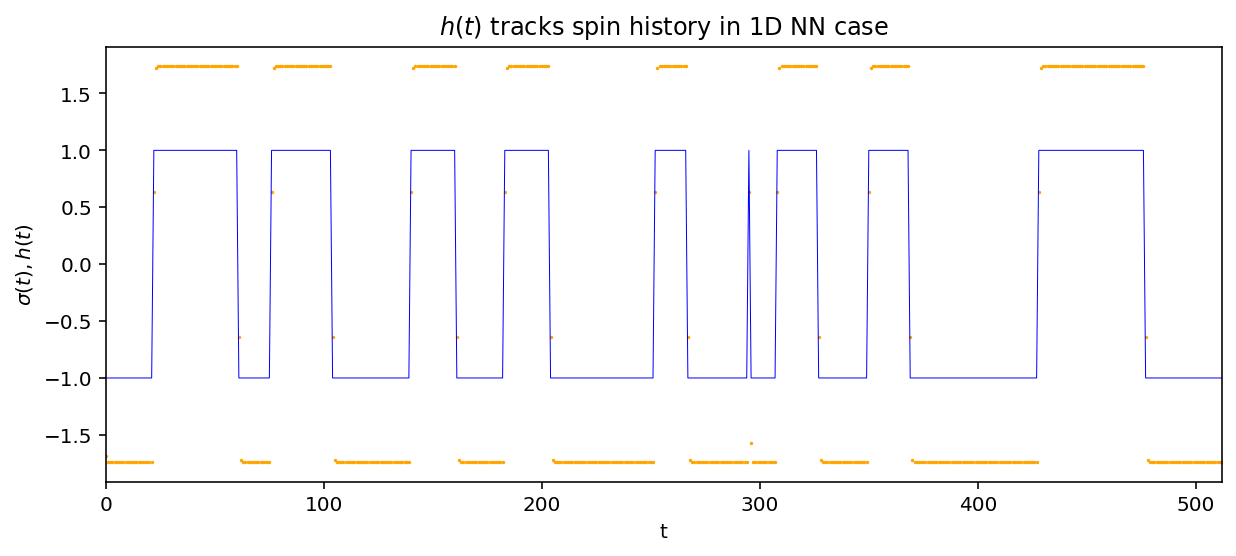

In [252]:
fig = spin_history(spindata, hdata)

(<Figure size 432x288 with 1 Axes>,
 (array([12.11210561,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        , 12.88788097]),
  array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
         -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
         -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
      

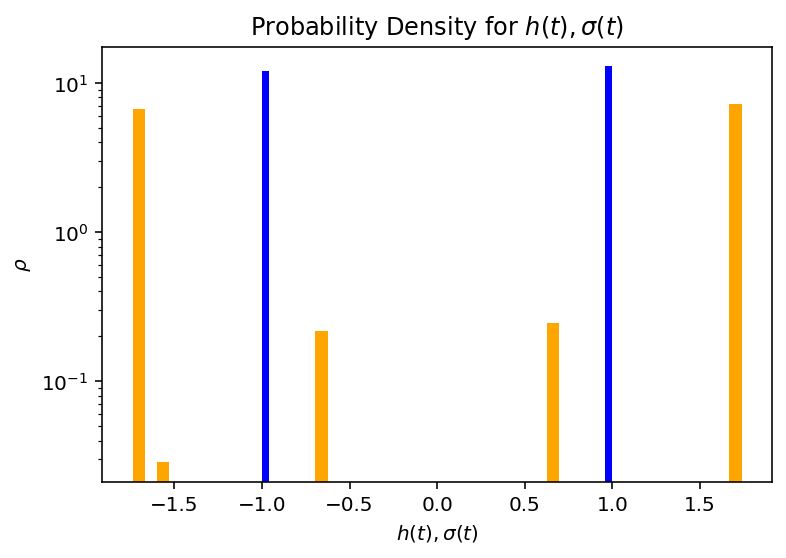

In [257]:
spin_dynamics_histogram(spindata, hdata, bin_count=50)

Did some more extensive simulations:

In [301]:
res_dir = os.path.join(RES_DIR, "1D/LR")
search_term = "arr_sampledata*"
raw_file_list = glob.glob(os.path.join(res_dir, search_term))

data_dir = os.path.join(DATA_DIR, "1D/LR")
data_filepath = "/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.7 0.2].npz"
K = [1., 0.7, 0.2]
dataset = SpinSequenceDataset(data_filepath, K)
dataloader = make_dataloader(dataset, num_samples=1, batch_size=1)

100%|██████████| 1/1 [00:00<00:00, 196.38it/s]


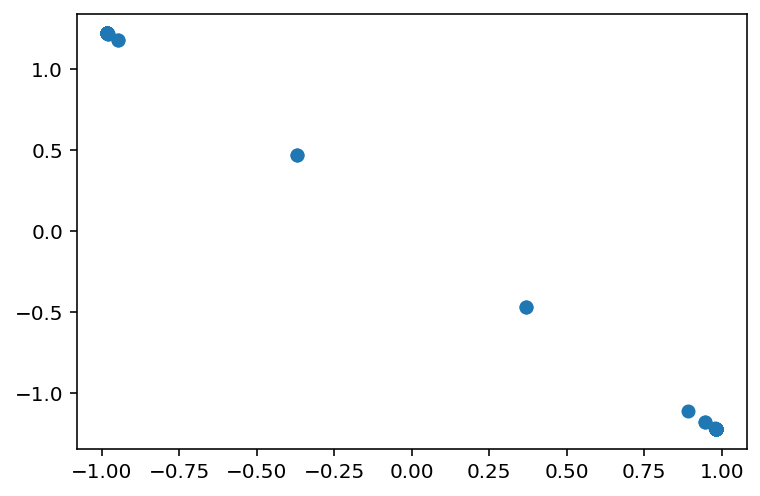

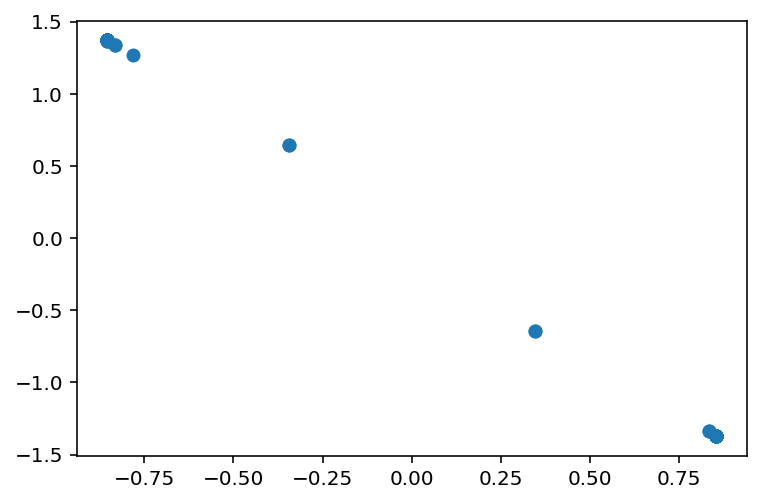

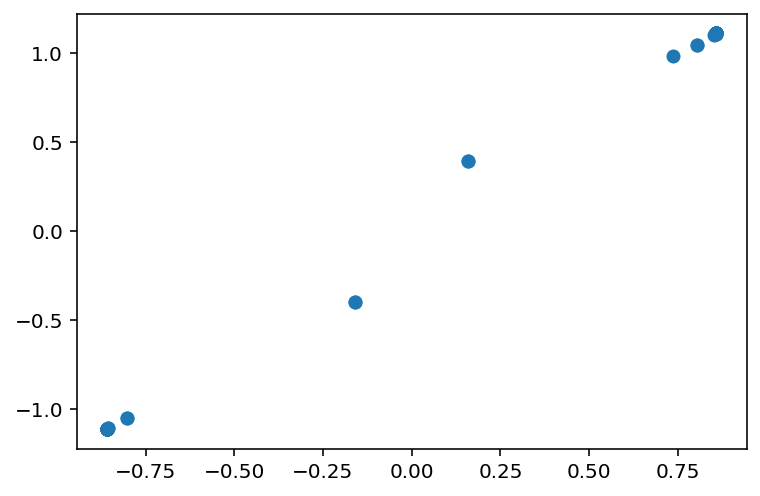

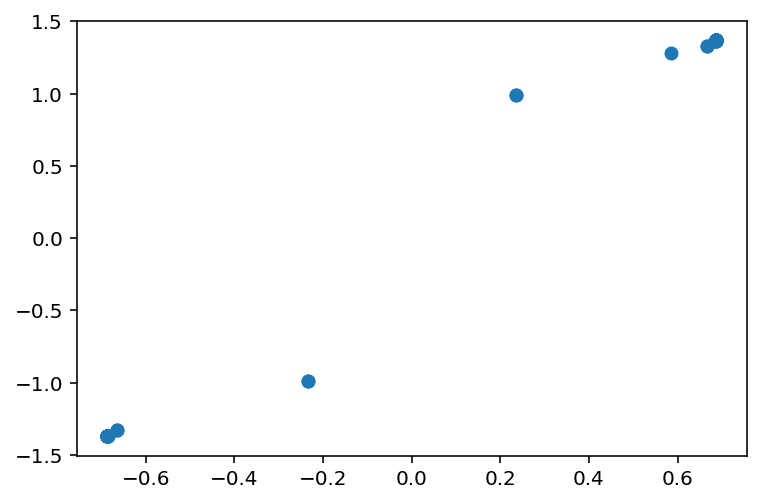

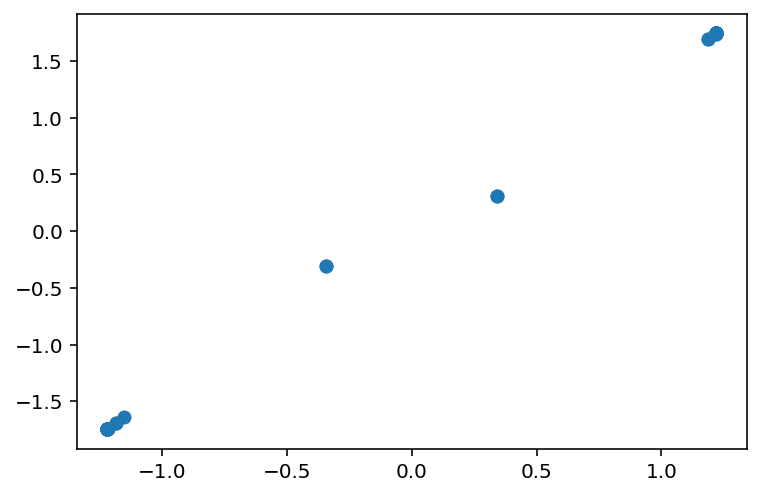

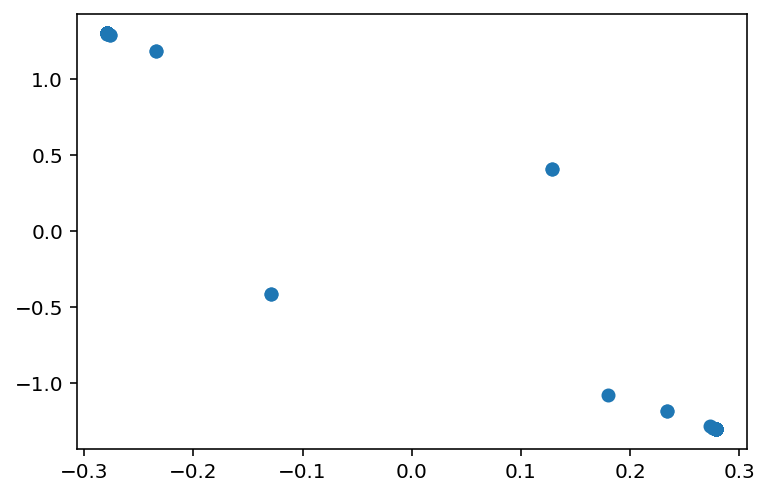

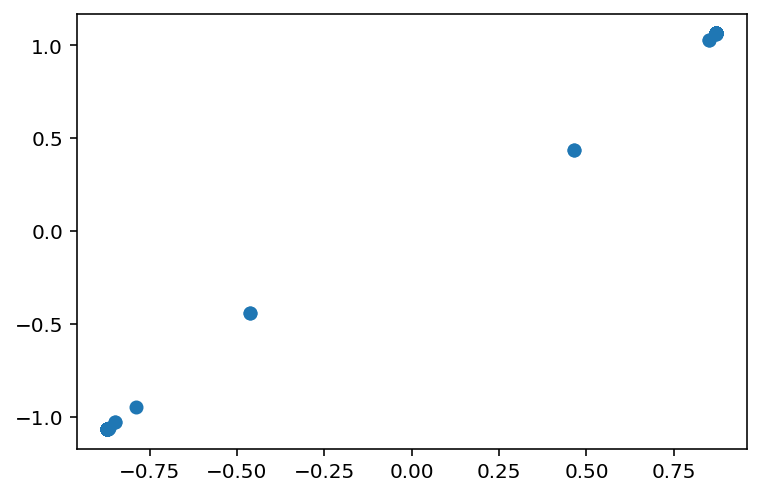

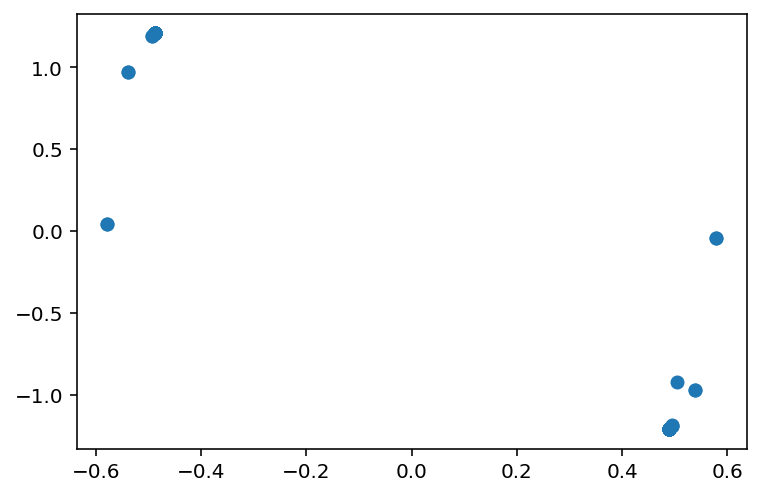

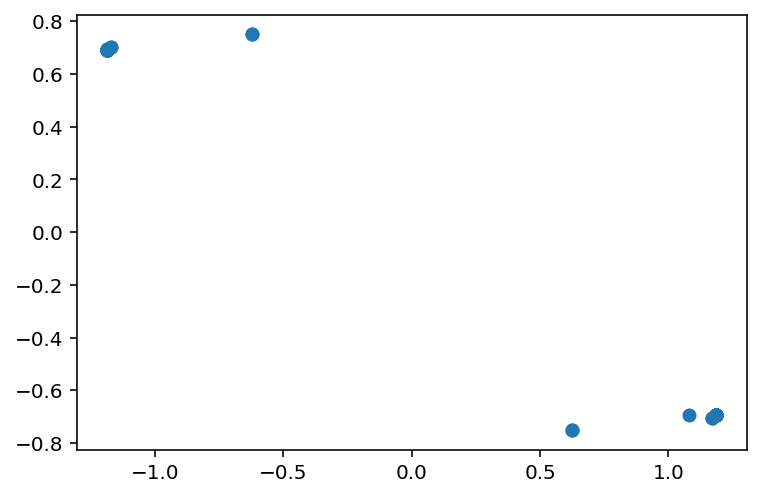

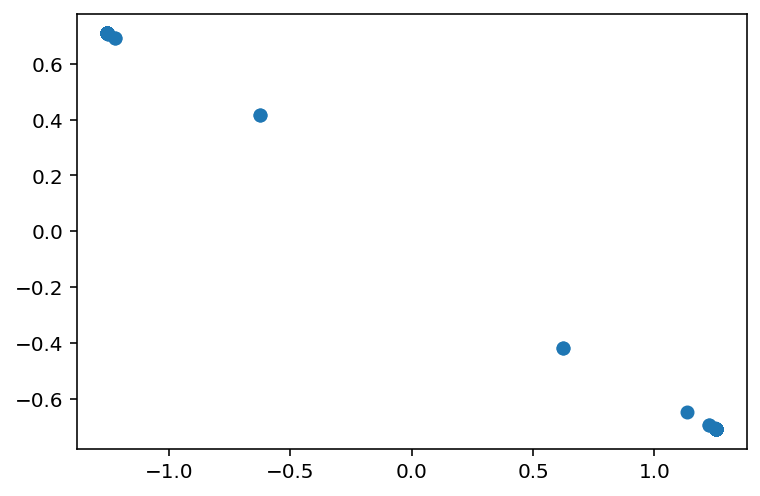

In [309]:
hidden_size = 2
log_dir = os.path.join(data_dir, f"macbook_K={K}")
for trial in np.arange(10):
    ckpt_dir = os.path.join(log_dir, f"hidden_size={hidden_size}/version_{trial}/checkpoints")
    ckpt, = os.listdir(ckpt_dir)
    ckpt_filepath = os.path.join(ckpt_dir, ckpt)
    model = IsingRNN_simple.load_from_checkpoint(ckpt_filepath)
    s, h = get_hdata(model, dataloader, num_samples=1)
    spindata, hdata = s[0], h[0]
    plt.figure()
    plt.scatter(hdata[:,0], hdata[:,1])
#    plt.plot(spindata, c="k")
#    plt.scatter(x=np.arange(999),y=hdata, s=0.1, alpha=0.5)


# 2D

In [116]:
kfrac_list = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1]

## Apr 23 scratch

In [25]:
loss_arr = []
for hidden_size in np.arange(10)+1:
    ckpt_dir = f"/Users/jesselin/Dropbox/src/thesis/final/data/2D/macbook_kfrac=1.0/hidden_size={hidden_size}/version_0/checkpoints/"
    ckpt = os.path.join(ckpt_dir, os.listdir(ckpt_dir)[0])
    model = IsingRNN_simple.load_from_checkpoint(ckpt)
    loss_arr.append(model.loss_history)
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/2D/macbook_kfrac=1.0/hidden_size=10/version_2/checkpoints/epoch=23-step=239.ckpt")
unique_loss = model.loss_history

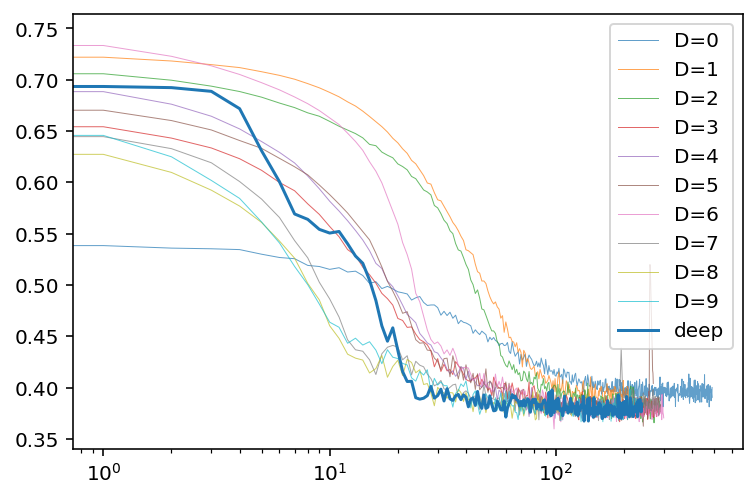

In [26]:
for i,l in enumerate(loss_arr):
    plt.plot(l, label=f"D={i}", linewidth=0.5, alpha=0.7)
plt.plot(unique_loss, label="deep")
plt.xscale("log")
plt.legend()

### Get spinsequence data

In [31]:
get_entropy(dimension=1, interaction_K=[3])

0.01731142407753916

In [117]:
def get_spin_file(kfrac):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn_compiled/test_res_dir/compiled tensors"
    search_term = "compiled*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    spin_file_dict = {round(1/float(get_T(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    return spin_file_dict[kfrac], spin_file_dict

## Get trained RNNs

In [1279]:
def get_model(kfrac, hidden_size, trial_num):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn/2d_cluster_data/compiled tight nn"
    search_term = "logs_2D*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    model_dir_dict = {round(float(get_K(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    checkpoint_dir = os.path.join(model_dir_dict[kfrac], f"hidden_size={hidden_size}/version_{trial_num}/checkpoints")
    checkpoint_basename, = os.listdir(checkpoint_dir)
    checkpoint = os.path.join(checkpoint_dir, checkpoint_basename)
    return IsingRNN_compat.load_from_checkpoint(checkpoint)

In [1285]:
# outline
kfrac = 1
hidden_size = 2
trial_num = 1

spin_filepath, _ = get_spin_file(kfrac)
dataset = SpinSequenceDataset(spin_filepath, interaction_K=[kfrac*INTERACTION_Kc])
num_samples = len(dataset)
model = get_model(kfrac, hidden_size, trial_num)
spindata_arr, hdata_arr = get_hdata(model, dataset, num_samples=10)

100%|██████████| 10/10 [00:00<00:00, 83.19it/s]


In [1281]:
for x in hdata_arr:
    y = pca(x, pc_count=1)
    evals = y[1]
    print("Variance captured", np.max(evals)/np.sum(evals))

Variance captured 0.691384
Variance captured 0.8526054
Variance captured 0.7874489
Variance captured 0.72694147
Variance captured 0.7770812
Variance captured 0.86172706
Variance captured 0.76641345
Variance captured 0.8456583
Variance captured 0.75769746
Variance captured 0.7017953


In [1287]:
hdata = hdata_arr[0]

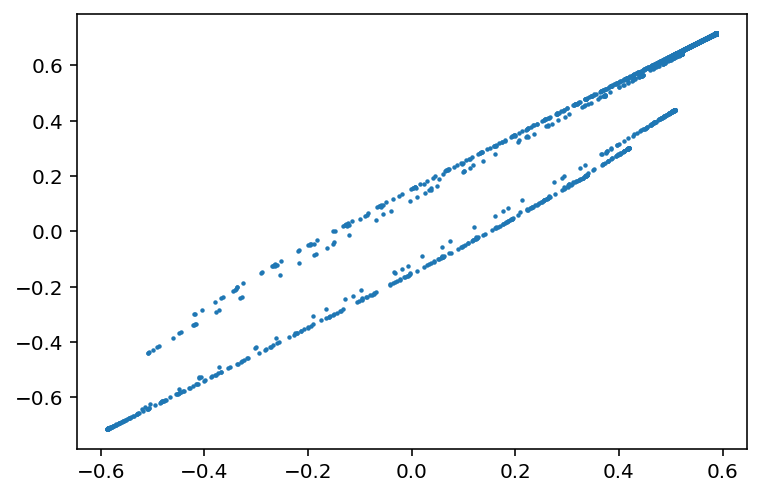

In [1288]:
y, _, _ = pca(hdata_arr[0], pc_count=2)
plt.scatter(hdata[:,0], hdata[:,1], s=1.5)

In [162]:
spindata = spindata_arr[0]
hdata = hdata_arr[0]
if hidden_size == 1:
    reduced_hdata = hdata
else:
    reduced_hdata, evals, _ = pca(hdata_arr[0], pc_count=1)
reduced_hdata = reduced_hdata/np.max(reduced_hdata)*0.8

Text(0.5, 1.0, '$h(t)$ compared to 2D critical sequences')

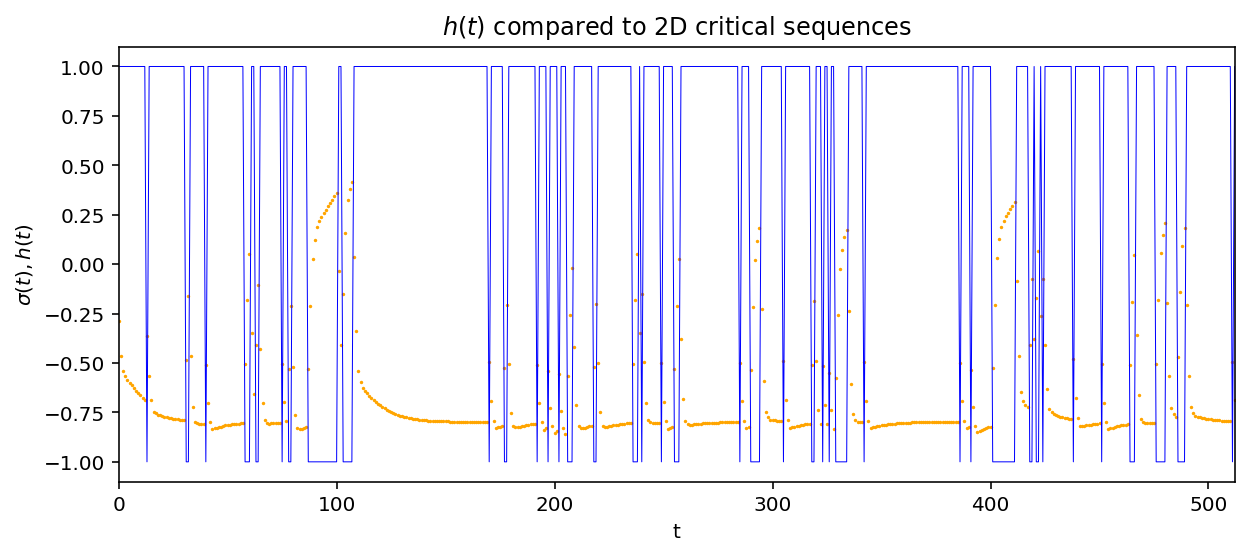

In [163]:
plt.figure(figsize=(10,4))
xdata = np.arange(len(reduced_hdata))
plt.plot(xdata, spindata, linewidth=0.5,c="blue")
plt.scatter(xdata, reduced_hdata, s=0.5,c="orange")
plt.xlim([0,512])
plt.ylabel(r"$\sigma(t), h(t)$")
plt.xlabel(r"t")
plt.title(r"$h(t)$ compared to 2D critical sequences")

Text(0, 0.5, '$\\rho$')

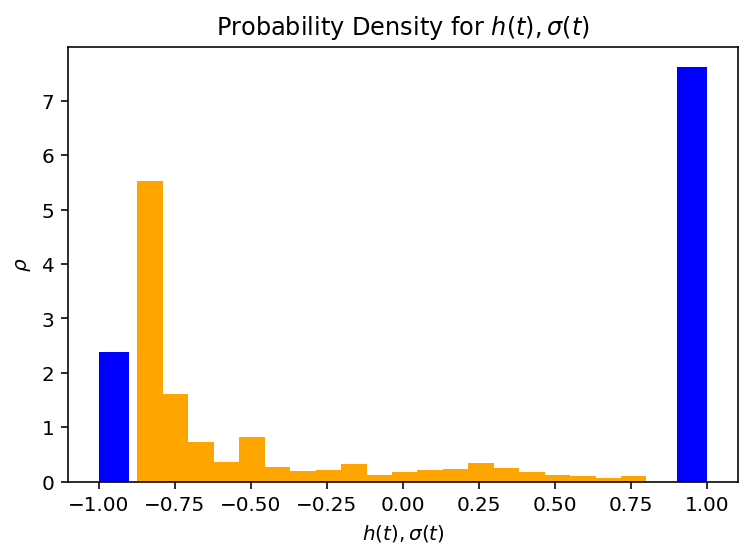

In [164]:
bin_count = 20
hist_spindata = plt.hist(spindata, bins=bin_count, density=True, color="blue")
hist_hdata = plt.hist(reduced_hdata, bins=bin_count, density=True, color="orange")
plt.title(r"Probability Density for $h(t), \sigma(t)$")
plt.xlabel(r"$h(t),\sigma(t)$")
plt.ylabel(r"$\rho$")

## Process data

In [ ]:
kfrac_list = 0.9 + np.arange(21)*0.01

In [ ]:
res_dir_2d = os.path.join(RES_DIR, "2D")
res_dir_compiled_tensor = os.path.join(res_dir_2d, "compiled tensors")

In [ ]:
search_term = "compiled*"
raw_file_list = glob.glob(os.path.join(res_dir_compiled_tensor, search_term))
# assemble dictionary
def get_exp_num(filepath):
    basename = os.path.basename(f)
    basename, file_ext = os.path.splitext(basename)
    exp_num = basename.split("_")[4].split("=")[-1]
    return int(exp_num)

def get_temperature(filepath) -> str:
    basename = os.path.basename(f)
    basename, file_ext = os.path.splitext(basename)
    temperature_str = basename.split("_")[5].split("=")[-1]
    return temperature_str

file_dict = {}
for f in raw_file_list:
    temperature = get_temperature(f)
    kfrac_str = str(round(1/float(temperature)/INTERACTION_Kc,2))
    file_dict[kfrac_str] = f

In [9]:
dataset = SpinSequenceDataset(file_dict["0.9"], interaction_K=[0.9])

In [11]:
dataloader = make_dataloader(dataset, num_samples=10)

## Train RNN

In [12]:
kfrac = float(1)
hidden_size = 1
log_dir = os.path.join(DATA_DIR, f"macbook_kfrac={str(kfrac)}")
model = IsingRNN_simple(hidden_size=hidden_size, num_layers=1, nonlinearity="tanh", bias_on=False)
logger = TensorBoardLogger(save_dir=log_dir, name=f"hidden_size={hidden_size}")
trainer = pl.Trainer(logger=logger, max_epochs = 650)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
trainer.fit(model, dataloader)


  | Name    | Type          | Params
------------------------------------------
0 | loss_fn | NLLLoss       | 0     
1 | rnn     | RNN           | 2     
2 | fc      | Linear        | 1     
3 | logprob | LogisticLayer | 0     
------------------------------------------
3         Trainable params
0         Non-trainable params
3         Total params
0.000     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_arm/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/thesis_arm/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller 

Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, loss=0.599, v_num=6]


AttributeError: 'int' object has no attribute '_metadata'

# Scratch Apr 23: 1D response functions

In [ ]:
def sech2(x):
    y = torch.cosh(x.detach())
    return (1/y**2).squeeze()

def linear_response(spindata, standardized_hdata, coupling_J, field_theta, mode=0):
    """ Takes spindata and standardized_hdata generated by get_hdata
    (appropriately offsets, and does PCA, before calculation)
    mode=0 means no denom, mode=1 means yes denom"""
    if len(standardized_hdata.squeeze().shape) == 1:
        hidden_dim = 1
    else:
        hidden_dim = standardized_hdata.shape[-1]
        standardized_hdata, _, evecs = pca(standardized_hdata, pc_count=1)
    coupling_J = coupling_J.detach().squeeze()
    field_theta = field_theta.detach().squeeze()

    # project field_theta onto the PC eigenvector
    if evecs is not None:
        evecs = torch.tensor(evecs)
        principal_evec = evecs[0]
        field_theta = torch.matmul(field_theta, principal_evec)
        temp = torch.matmul(coupling_J, evecs)
        coupling_J = torch.matmul(evecs.T, coupling_J)

    spins = torch.tensor(spindata)
    jh = torch.tensor(hdata)
    # jh shifted into the past 1, for addition in tanh
    jhm1 = torch.concat((torch.tensor([0.]),jh))[:-1]
    jhm1 = jhm1.squeeze()

    thetaspins = field_theta*spins
    thetaspins = thetaspins.squeeze()

    numerator = sech2(jhm1 + thetaspins)
    if mode == 1:
        denominator = 1 - torch.matmul(coupling_J.reshape(1, hidden_dim, hidden_dim), numerator.reshape(-1, 1, hidden_dim))
        denominator = denominator.squeeze()
    else:
        denominator = 1
    return numerator/denominator


In [720]:
data_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn/macbook_simple_1D"
dataset = SpinSequenceDataset(
    "/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1. 0. 0.].npz", 1)
hidden_size = 1
model = IsingRNN_simple_compat.load_from_checkpoint(
    f"/Users/jesselin/Dropbox/src/thesis/experiments/rnn/macbook_simple_1D/hidden_size={hidden_size}/version_0/checkpoints/epoch=14-step=374.ckpt")

In [ ]:
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.7].npz", 1)
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.7]/hidden_size=1/version_0/checkpoints/epoch=99-step=999.ckpt")

In [714]:
dataset = SpinSequenceDataset("/Users/jesselin/Dropbox/src/thesis/final/resources/1D/LR/arr_sampledata_K=[1.  0.7 0.2].npz", 1)
model = IsingRNN_simple.load_from_checkpoint("/Users/jesselin/Dropbox/src/thesis/final/data/1D/LR/adroit_K=[1.0, 0.7, 0.2]/hidden_size=1/version_0/checkpoints/epoch=99-step=999.ckpt")

In [970]:
# outline
kfrac = 1
hidden_size = 2
trial_num = 2

spin_filepath, _ = get_spin_file(kfrac)
dataset = SpinSequenceDataset(spin_filepath, interaction_K=[kfrac*INTERACTION_Kc])
num_samples = len(dataset)
model = get_model(kfrac, hidden_size, trial_num)
spindata_arr, hdata_arr = get_hdata(model, dataset, num_samples=10)

100%|██████████| 10/10 [00:00<00:00, 119.01it/s]


In [971]:
coupling_J = model.rnn.weight_hh_l0
field_theta = model.rnn.weight_ih_l0
spindata_arr, hdata_arr = get_hdata(model, dataset, num_samples=1)

100%|██████████| 1/1 [00:00<00:00, 125.83it/s]


In [972]:
spindata, hdata = spindata_arr[0], hdata_arr[0]

In [973]:
if len(hdata.squeeze().shape) == 1:
    hidden_dim = 1
else:
    hidden_dim = hdata.shape[-1]
    hdata, evals, evecs = pca(hdata, pc_count=1)
coupling_J = coupling_J.detach().squeeze()
field_theta = field_theta.detach().squeeze()


In [974]:
evecs = torch.tensor(evecs)
principal_evec = evecs[0]
field_theta = torch.matmul(field_theta, principal_evec)


In [975]:
temp = torch.matmul(coupling_J, principal_evec)
coupling_J = torch.matmul(principal_evec, temp)


In [976]:
spins = torch.tensor(spindata)
jh = torch.tensor(hdata)
jh = jh.squeeze()
# jh shifted into the past 1, for addition in tanh
jhm1 = torch.concat((torch.tensor([0.]),jh))[:-1]
jhm1 = jhm1.squeeze()

thetaspins = field_theta*spins
thetaspins = thetaspins.squeeze()

numerator = sech2(jhm1 + thetaspins)
mode = 1
response = numerator

(10.0, 256.0)

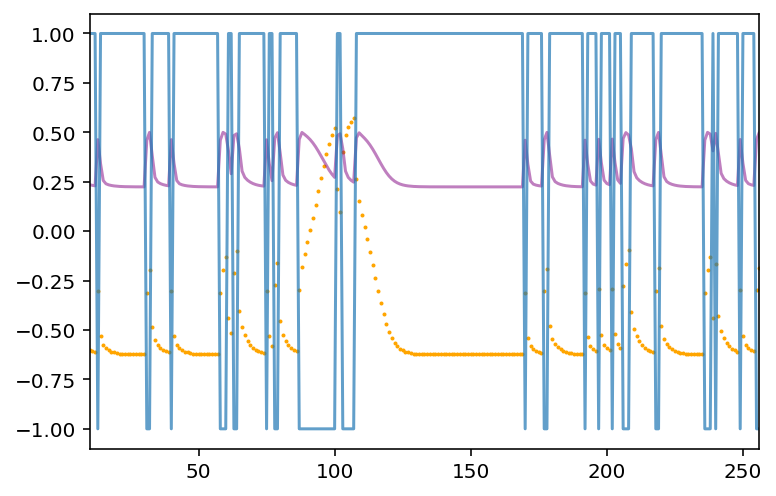

In [977]:
plt.plot(response*0.5, c="purple", alpha=0.5)
plt.plot(spindata, alpha=0.7)
plt.scatter(np.arange(2047), hdata, s=1, c="orange")
plt.xlim([10,256])

In [978]:
np.max(evals)/np.sum(evals)

0.9523082

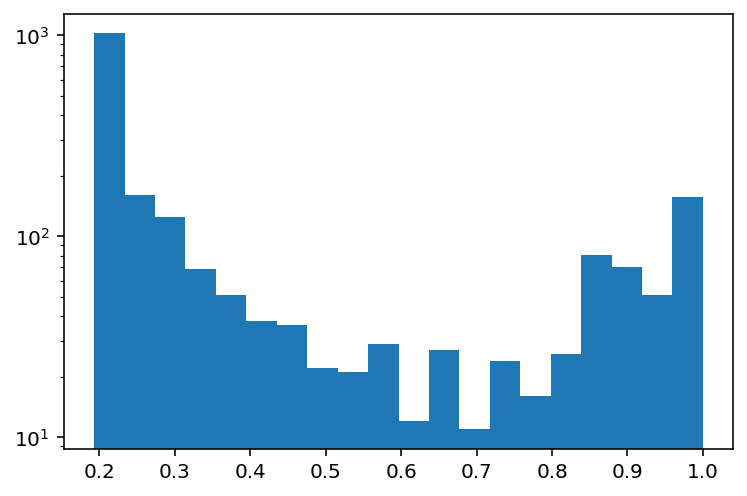

In [888]:
plt.hist(response.numpy(), bins=20)
plt.yscale("log")

## Try the Spectrum

In [92]:
def get_eval_ratio(model, two_state=False):
    if not two_state:
        transition_prob = torch.zeros((2,2))
        initial_conds = [[-1.],[1.]]
    elif two_state:
        transition_prob = torch.zeros((4,4))
        initial_conds = [[-1., -1.], [-1., 1.], [1., -1.], [1., 1.]]
    initial_conds = [torch.FloatTensor(x).reshape(1, -1, 1) for x in initial_conds]
    for i, x in enumerate(initial_conds):
        with torch.no_grad():
            a = model.forward(x)
            b = a[0].reshape(1,-1,2)
        probs = torch.exp(b[0, -1, :])
        if two_state:
            if i % 2 == 0:
                transition_prob[i,0] = probs[0]
                transition_prob[i,1] = probs[1]
            else:
                transition_prob[i,2] = probs[0]
                transition_prob[i,3] = probs[1]
        else:
            transition_prob[i] = probs
    evals, evecs = torch.linalg.eigh(transition_prob)
    eval_ratio = evals[0]
    return eval_ratio.item()


In [110]:
data_dir = os.path.join(DATA_DIR, "2D")
search_term = "adroit*"
raw_file_list = sorted(glob.glob(os.path.join(data_dir, search_term)))

In [ ]:
for f in raw_file_list:
    plt.figure()
    plt.title(f"From file:{f}")
    for hidden_size in np.arange(5)+1:
        ckpt_dir = os.path.join(f, f"hidden_size={hidden_size}/version_0/checkpoints")
        ckpt, = os.listdir(ckpt_dir)
        ckpt = os.path.join(ckpt_dir, ckpt)
        model = IsingRNN_simple.load_from_checkpoint(ckpt)
        plt.plot(model.loss_history, label=f"D={hidden_size}")

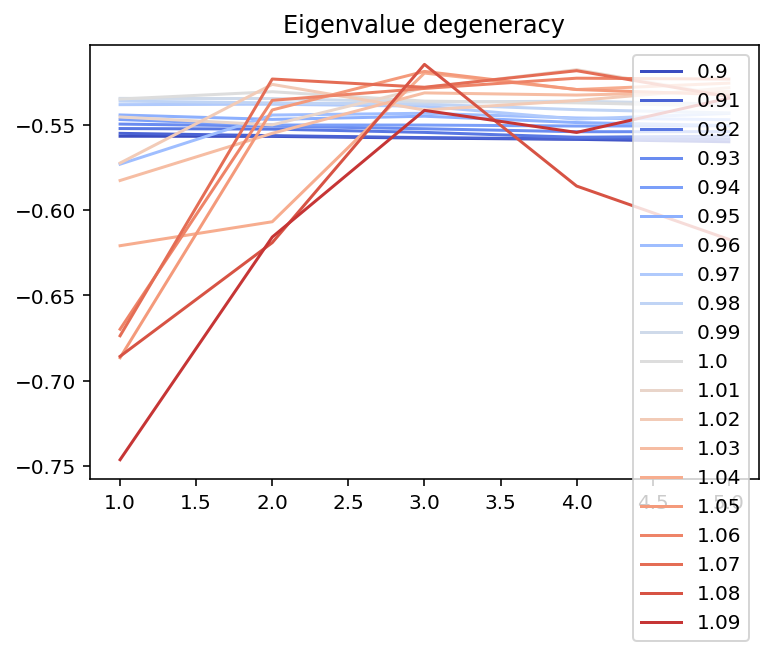

In [115]:
cmap = mpl.cm.get_cmap(name="coolwarm", lut=21)
for i, f in enumerate(raw_file_list):
    xdata = np.arange(5)+1
    ydata = []
    for hidden_size in xdata:
        ckpt_dir = os.path.join(f, f"hidden_size={hidden_size}/version_0/checkpoints")
        ckpt, = os.listdir(ckpt_dir)
        ckpt = os.path.join(ckpt_dir, ckpt)
        model = IsingRNN_simple.load_from_checkpoint(ckpt)
        eval_ratio = get_eval_ratio(model, two_state=True)
        ydata.append(eval_ratio)
    plt.plot(xdata, ydata, label=get_kfrac(f), c=cmap(i))
plt.title(f"Eigenvalue degeneracy")
plt.legend()


In [53]:
get_eval_ratio(model)

0.6919955611228943

In [23]:
prob_arr

(tensor([[[-1.8708, -0.1672]]], dtype=torch.float64),
 tensor([[[-0.0712, -0.2127,  0.7971,  0.5899,  0.5452]]]),
 tensor([[[-0.0712, -0.2127,  0.7971,  0.5899,  0.5452]]]))

In [1]:
result_dict

NameError: name 'result_dict' is not defined

# Try the Corr func

In [12]:
def get_spin_file(kfrac):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/rnn_compiled/test_res_dir/compiled tensors"
    search_term = "compiled*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    spin_file_dict = {round(1/float(get_T(f))/INTERACTION_Kc, 2):f for f in raw_file_list}
    return spin_file_dict[kfrac], spin_file_dict

In [13]:
trial_num = 0
def get_model(kfrac, hidden_size, trial_num):
    res_dir = "/Users/jesselin/Dropbox/src/thesis/final/data/2D"
    search_term = "adroit*"
    raw_file_list = glob.glob(os.path.join(res_dir, search_term))
    raw_file_list.sort()
    model_dir_dict = {get_kfrac(f):f for f in raw_file_list}
    checkpoint_dir = os.path.join(model_dir_dict[str(kfrac)], f"hidden_size={hidden_size}/version_{trial_num}/checkpoints")
    checkpoint_basename, = os.listdir(checkpoint_dir)
    checkpoint = os.path.join(checkpoint_dir, checkpoint_basename)
    return IsingRNN_simple.load_from_checkpoint(checkpoint)

In [14]:
def rnn_generated_corrfunc(num_samples, model):
    generated_samples = []
    for _ in trange(num_samples):
        generated_sequence, hidden_sequence = model.generate_sequence(2048)
        if (generated_sequence[0] == -1.).item():
            generated_sequence *= -1
        generated_sequence = generated_sequence.numpy()
        generated_samples.append(generated_sequence)

    generated_samples = np.array(generated_samples)
    corrfunc_mean, corrfunc_stderr = np.mean(generated_samples, axis=0), np.std(generated_samples, axis=0)/np.sqrt(generated_samples.shape[0])
    return corrfunc_mean, corrfunc_stderr

In [15]:
def load_mc_corrfunc(kfrac):
    tmp = np.load(f"/Users/jesselin/Dropbox/src/thesis/experiments/2D_ising_processing/corrfunc_data/corrfunc_kfrac={str(kfrac)}.npz")
    mc_corrfunc = tmp["corrfunc"]
    mc_corrfunc_stderr = tmp["corrfunc_stderr"]
    return mc_corrfunc, mc_corrfunc_stderr

In [ ]:
# Time to compare
trial_num = 0
data_dir = "/Users/jesselin/Dropbox/src/thesis/experiments/2D_ising_processing/corrfunc_comparison"
for hidden_size in np.arange(5)+1:
    cf_dict = {}
    for kfrac in np.array([0.9, 0.95, 1.0, 1.05, 1.09]):
        model = get_model(kfrac, hidden_size, trial_num)
        rnn_cf, rnn_cf_stderr = rnn_generated_corrfunc(1000, model)
        mc_cf, mc_cf_stderr = load_mc_corrfunc(kfrac)
        cf_dict[str(kfrac)] = ((rnn_cf, rnn_cf_stderr), (mc_cf, mc_cf_stderr))

    filepath = os.path.join(data_dir, f"cf_dict_hidden_size={hidden_size}")
    with open(filepath, "wb") as f:
        pickle.dump(cf_dict, f)

In [37]:
with open("/Users/jesselin/Dropbox/src/thesis/experiments/2D_ising_processing/corrfunc_comparison/cf_dict_hidden_size=1", "rb") as f:
    cf = pickle.load(f)

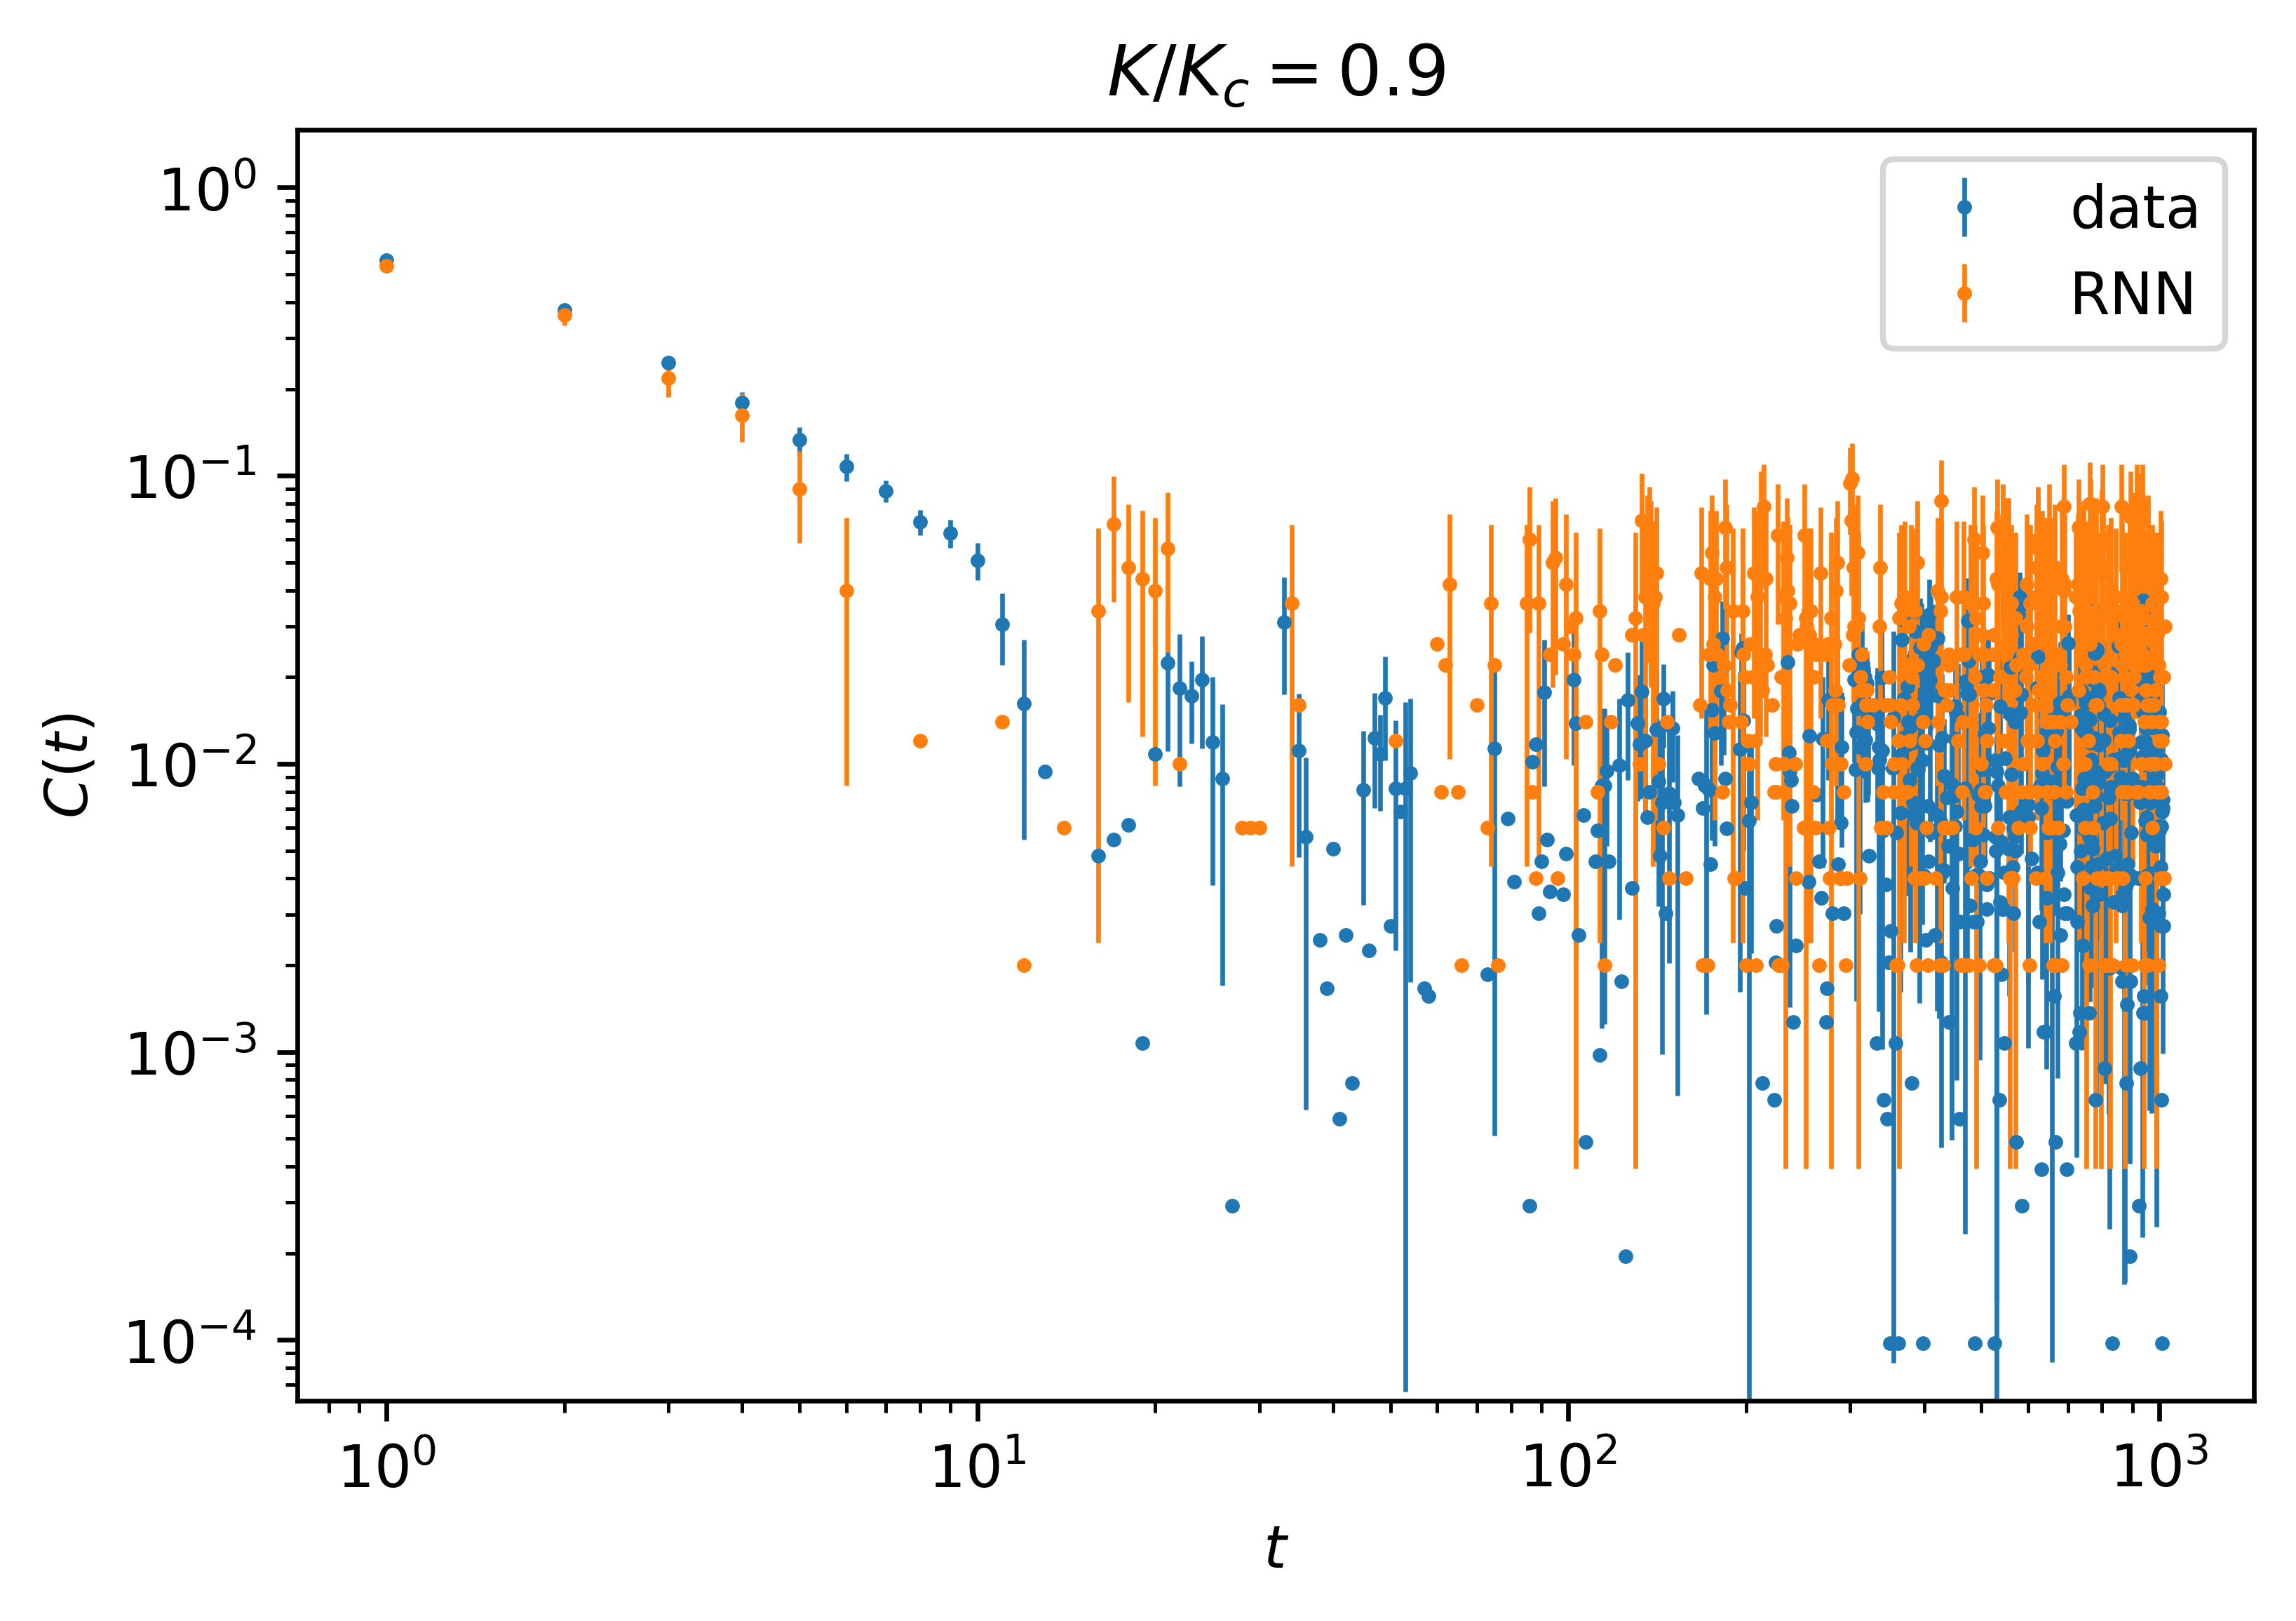

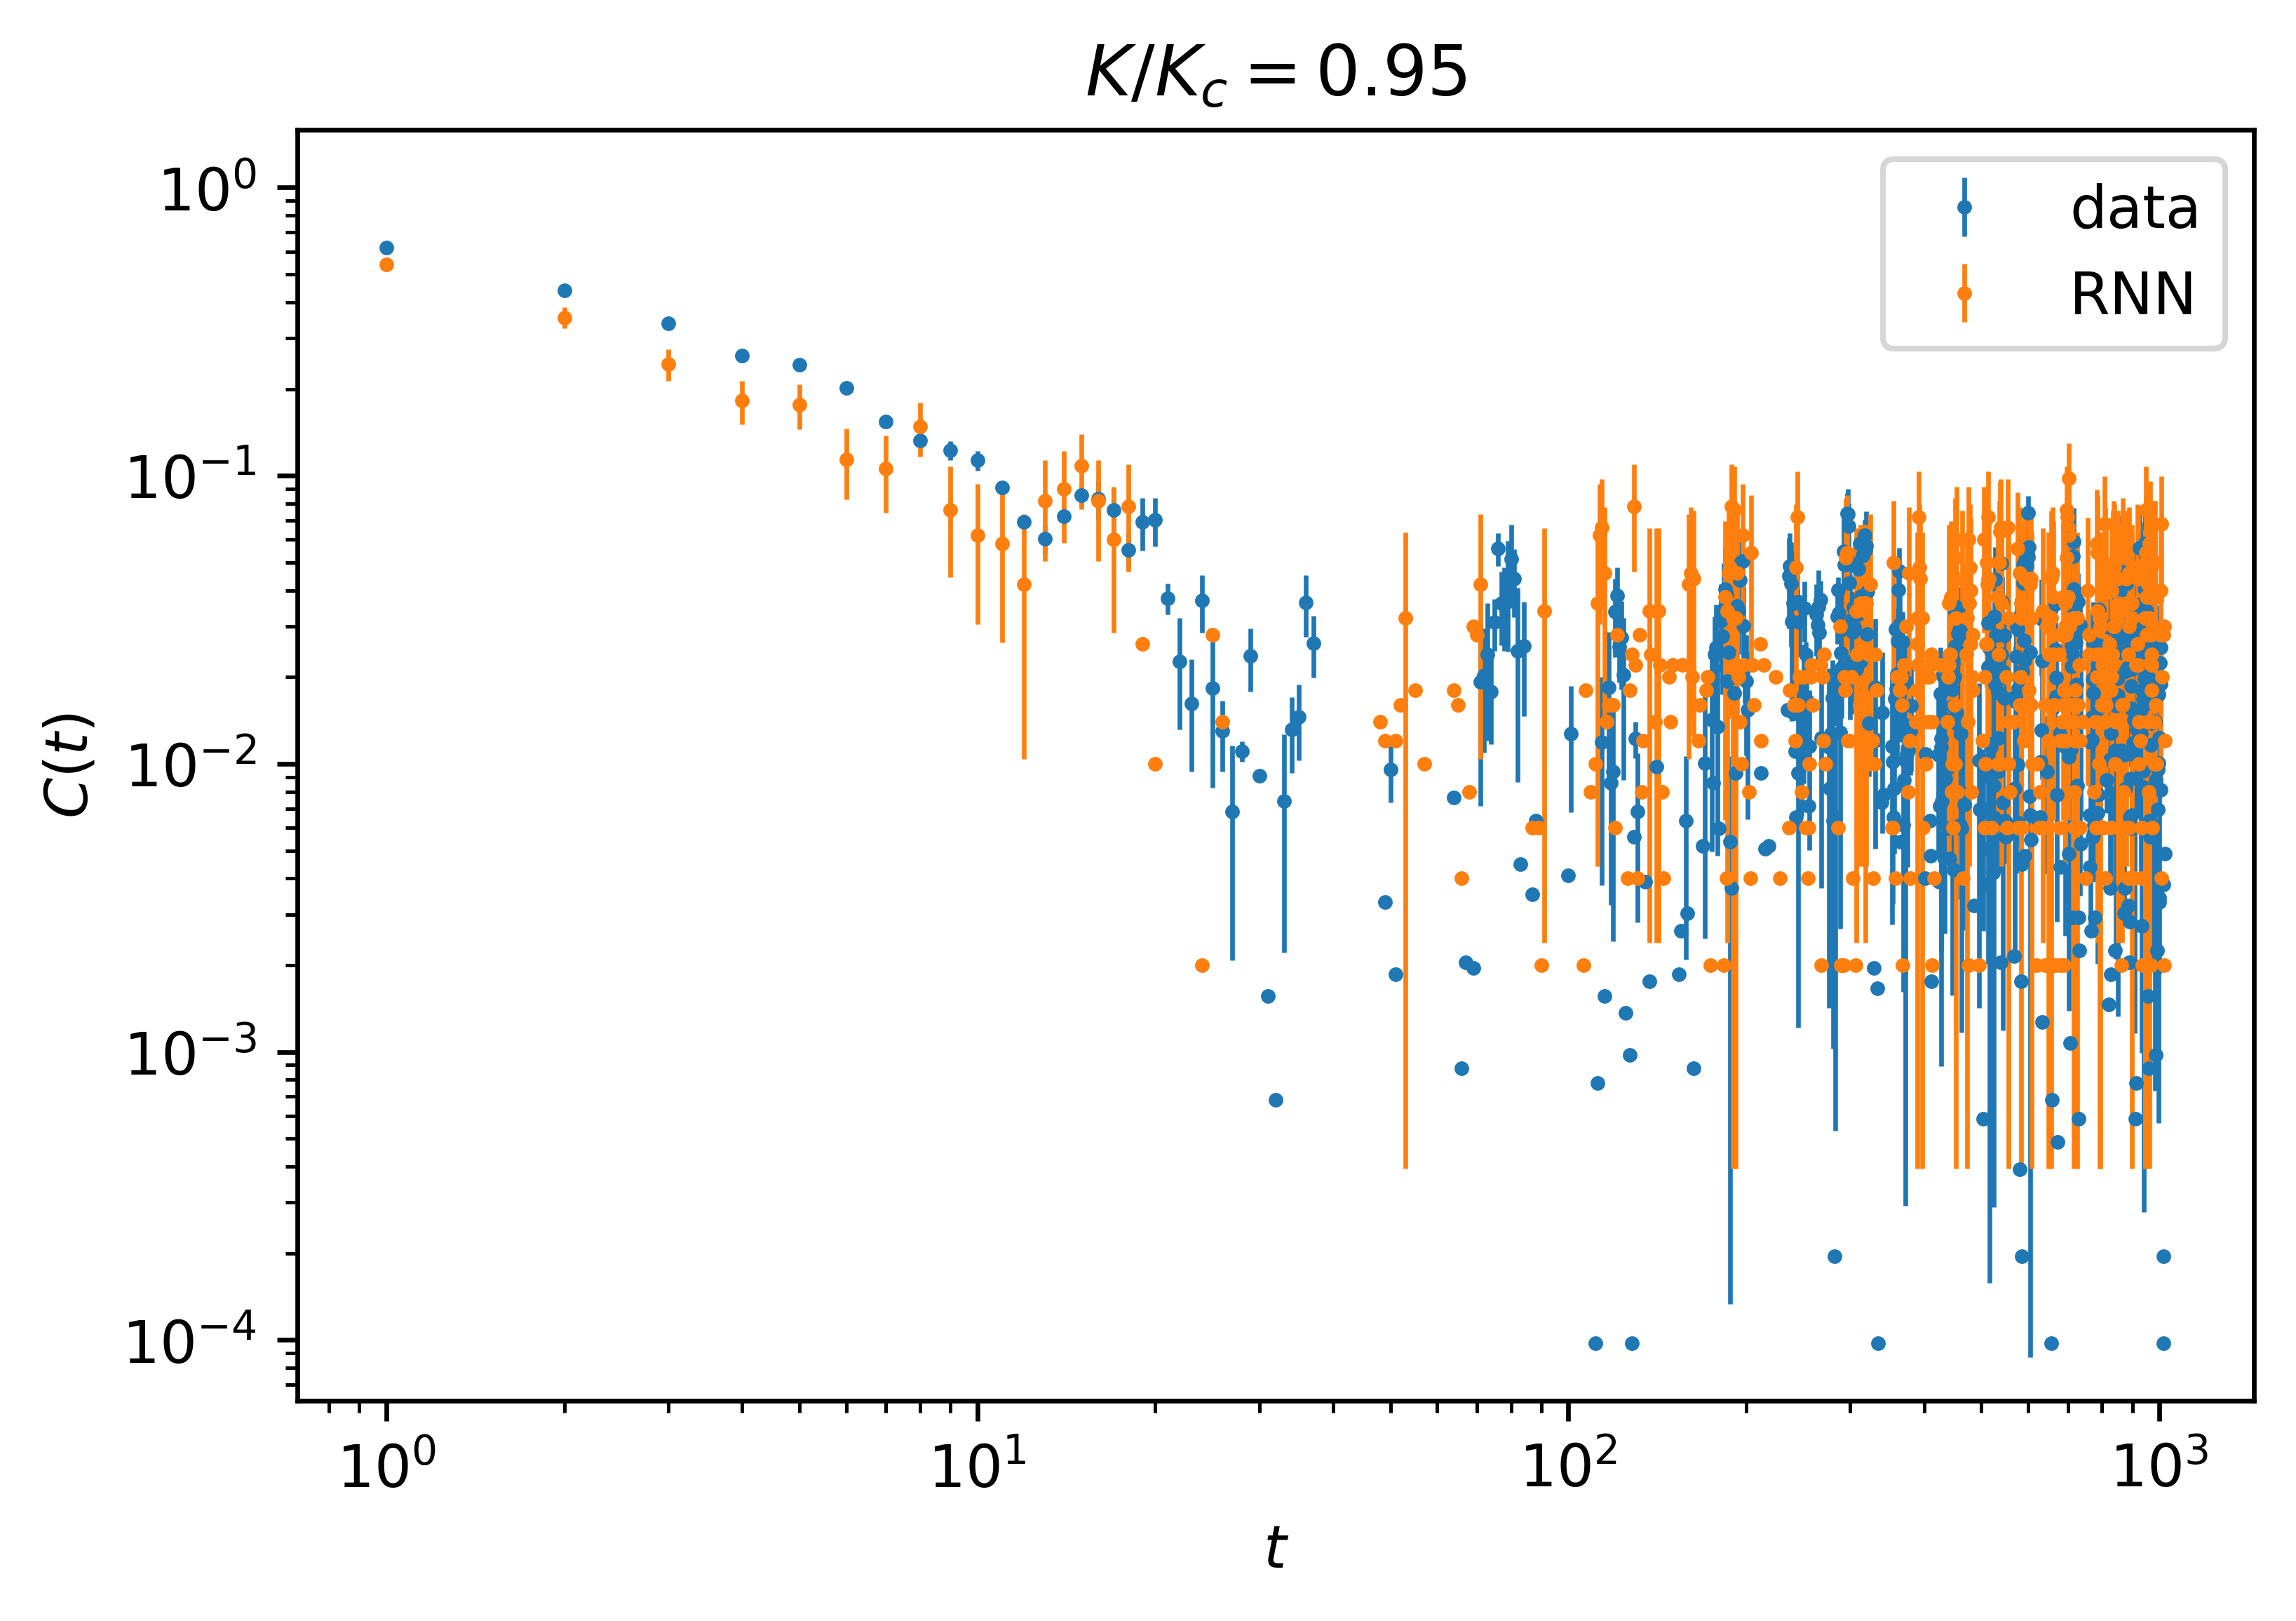

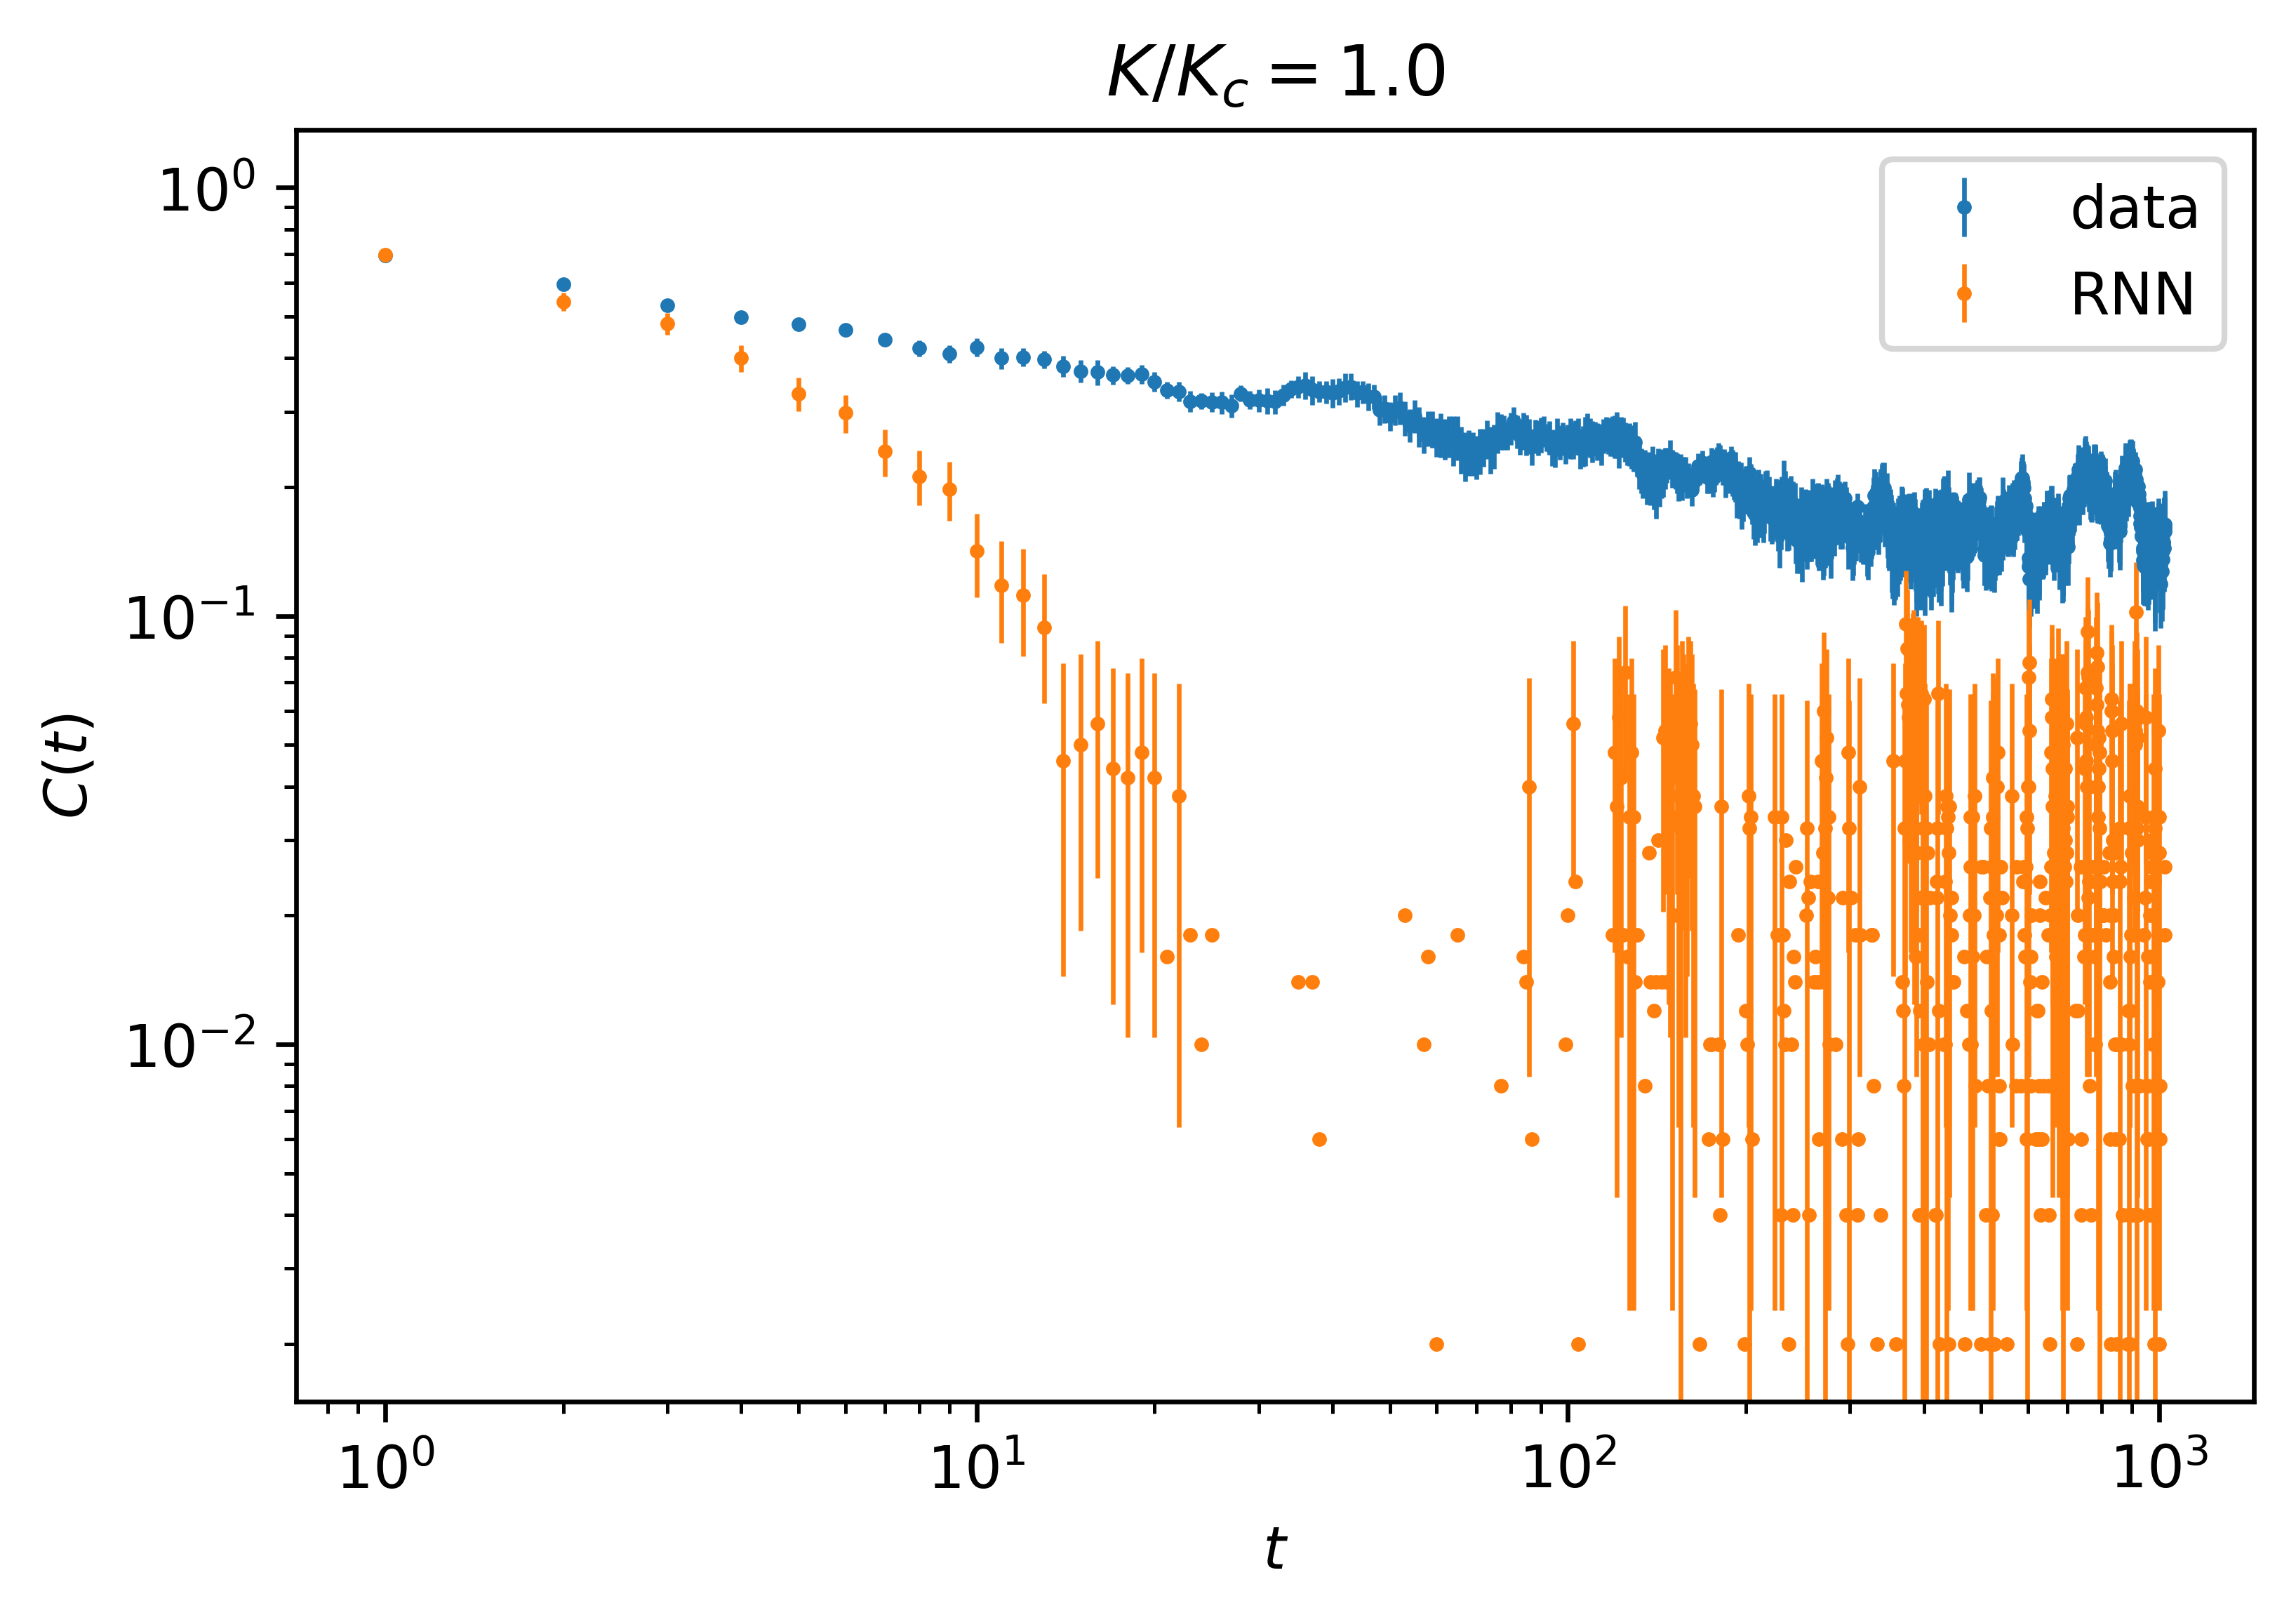

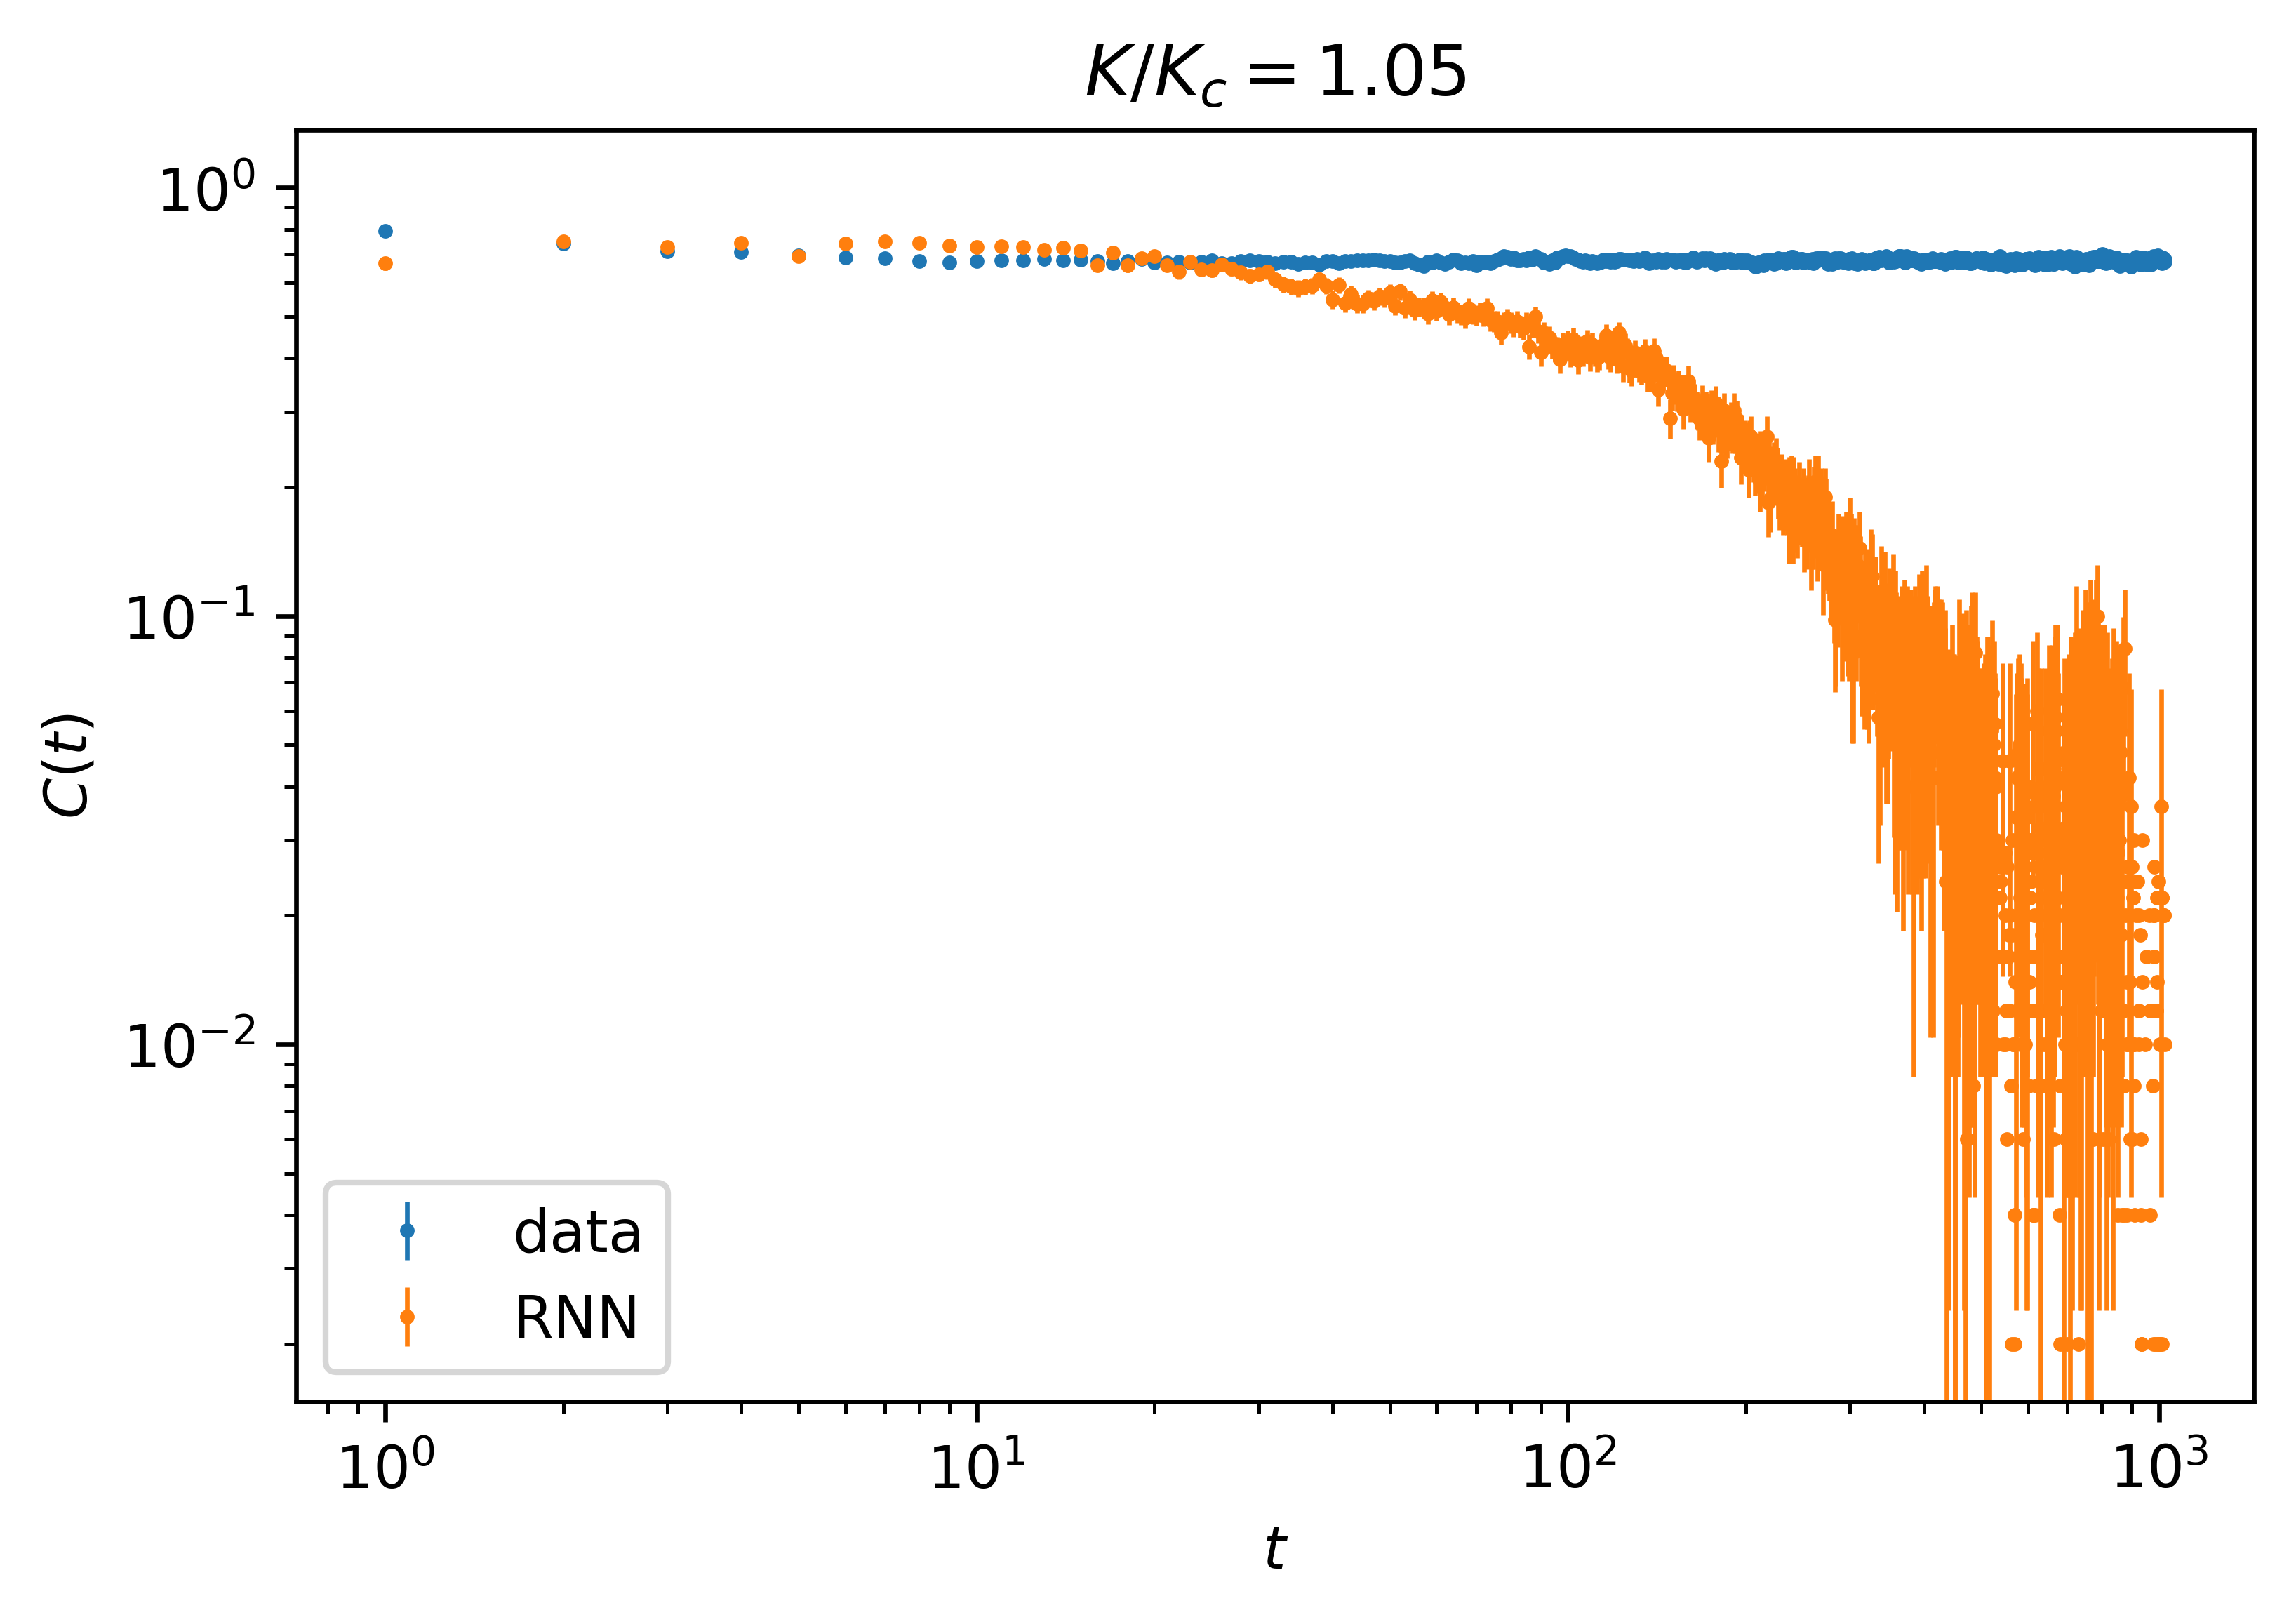

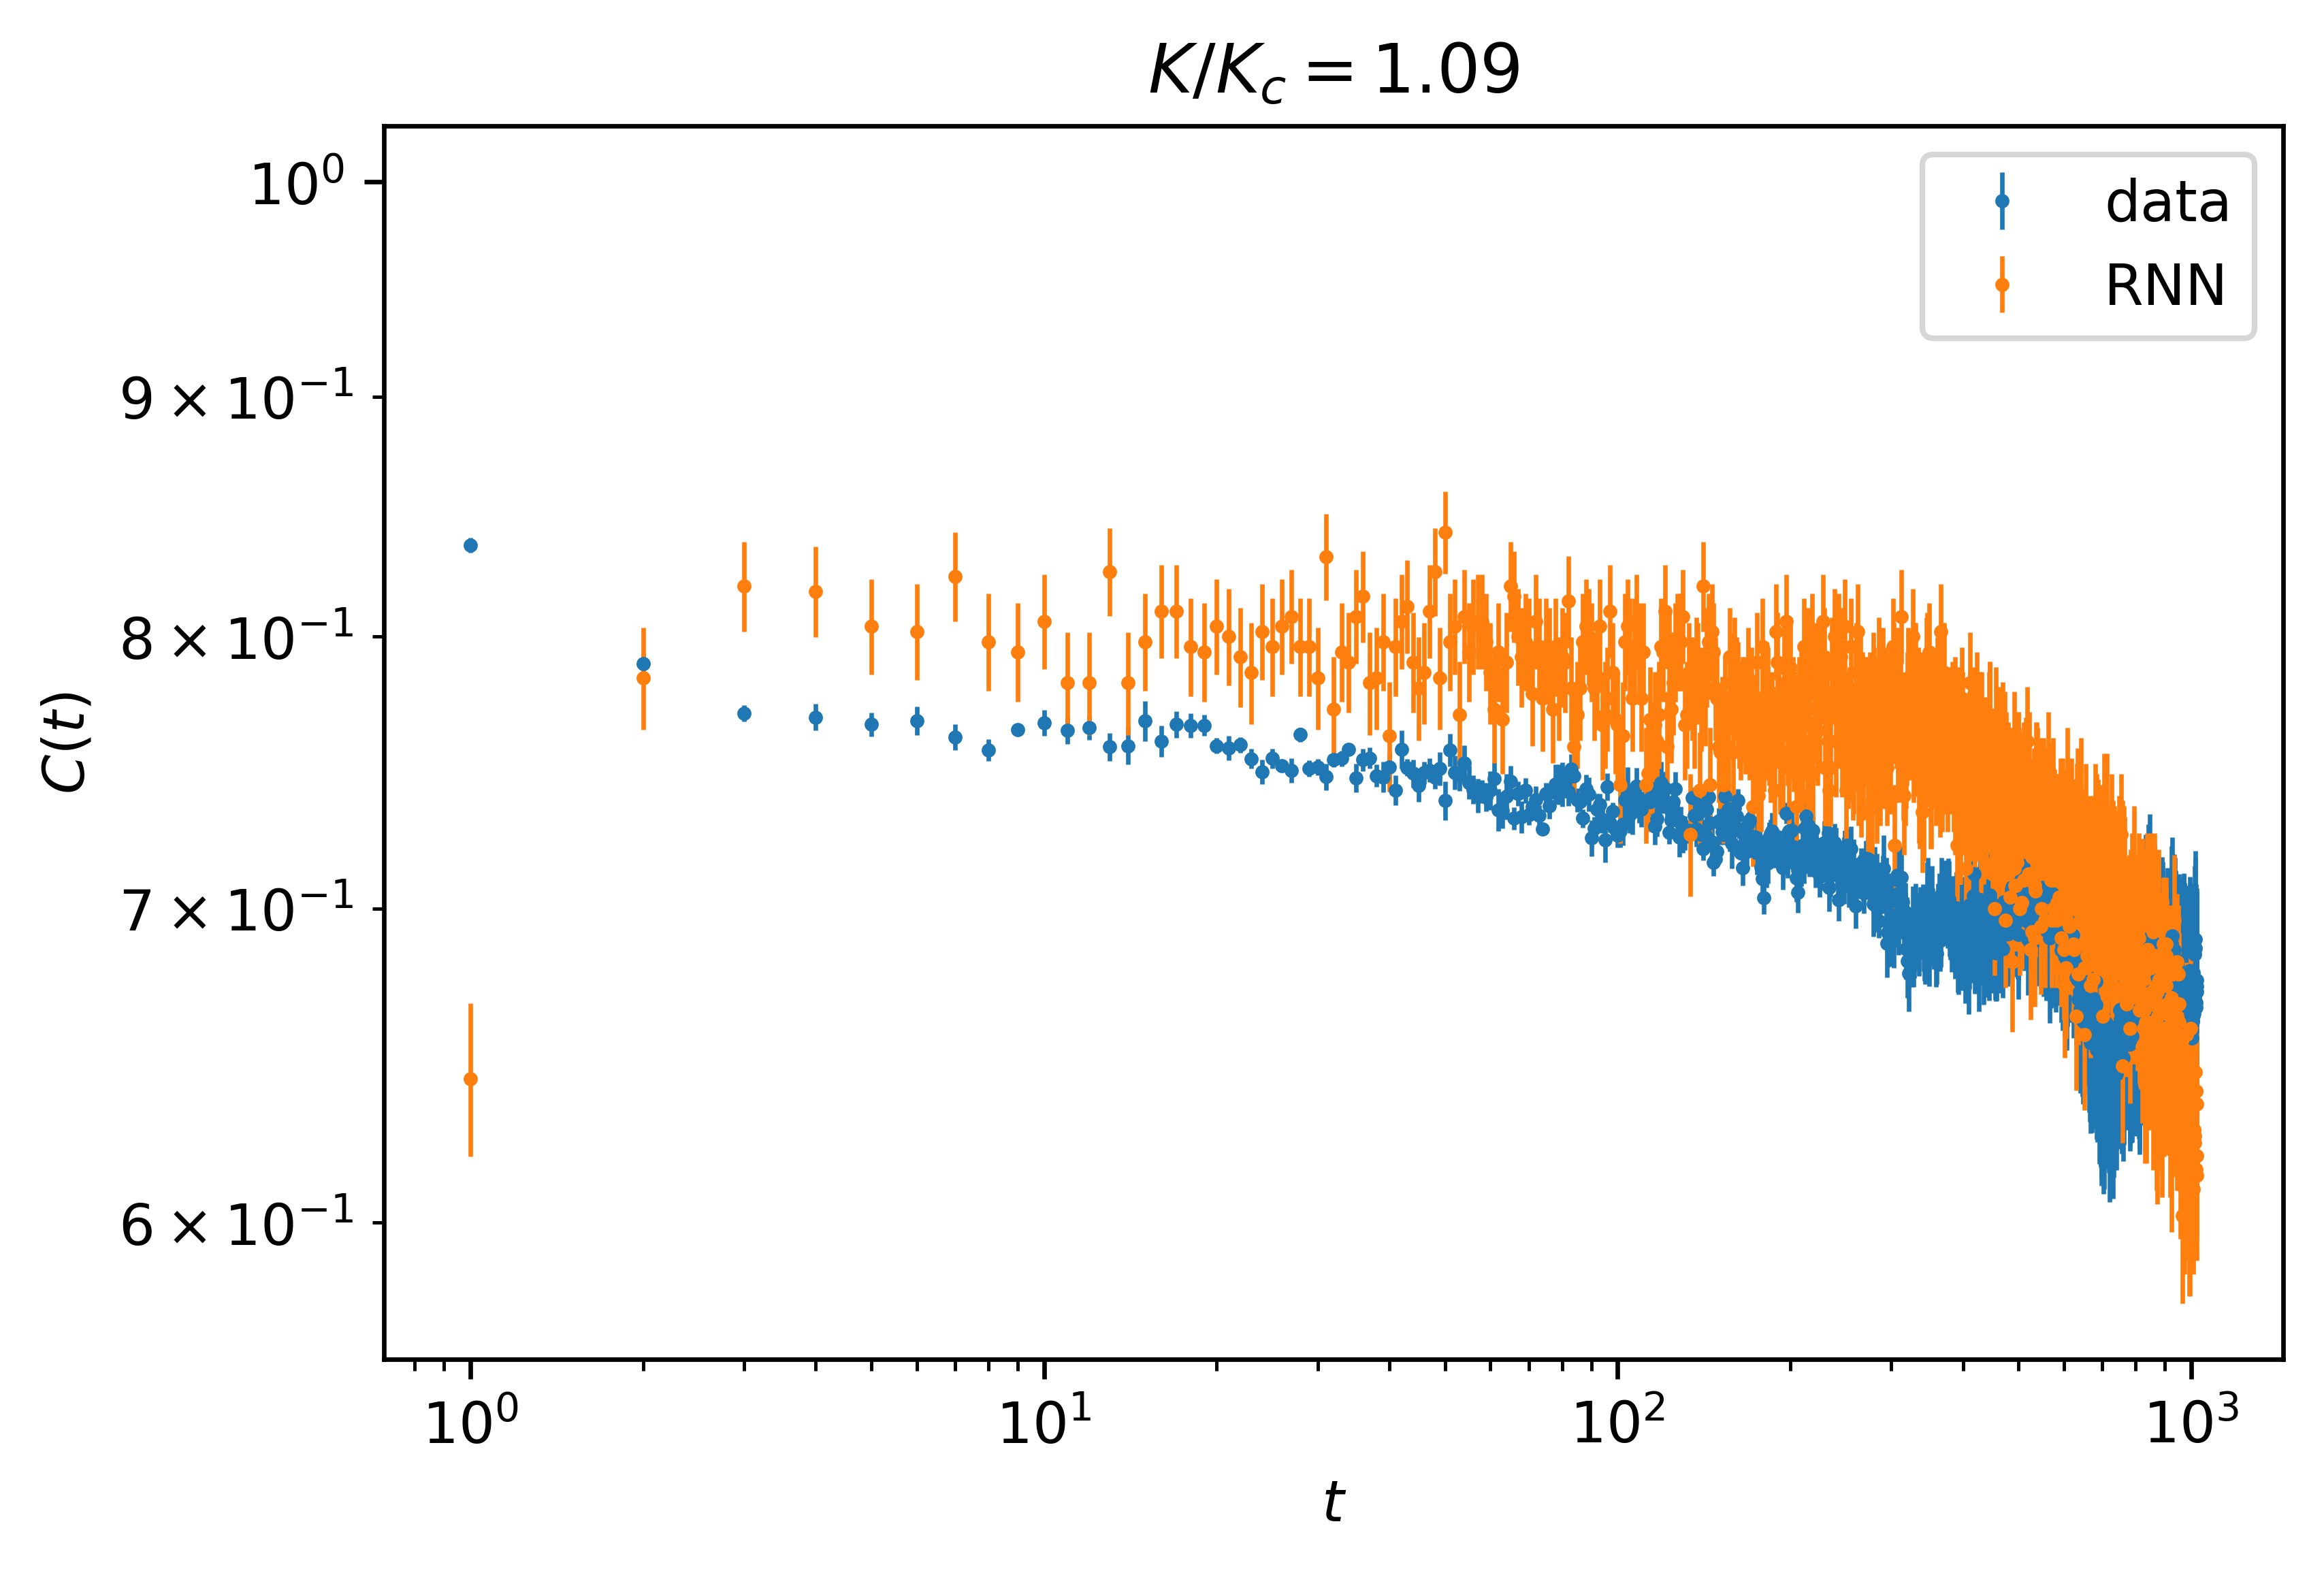

In [38]:
for kfrac, arrs in cf.items():
    rnn_cf, mc_cf = arrs
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(6,4)
    fig.set_dpi(300)
    plt.title(rf"$K/K_c={kfrac}$")
    plot_kwargs = {"linestyle":"none", "marker":".", "markersize":3, "elinewidth":0.8}
    plt.errorbar(x=np.arange(1024), y=mc_cf[0][:1024], yerr = mc_cf[1][:1024], label="data", **plot_kwargs)
    plt.errorbar(x=np.arange(1024), y=rnn_cf[0][:1024], yerr = rnn_cf[1][:1024], label="RNN", **plot_kwargs)
    plt.legend()
    plt.yscale("log", nonpositive="mask")
    plt.xscale("log")
    plt.ylabel(r"$C(t)$")
    plt.xlabel(r"$t$")


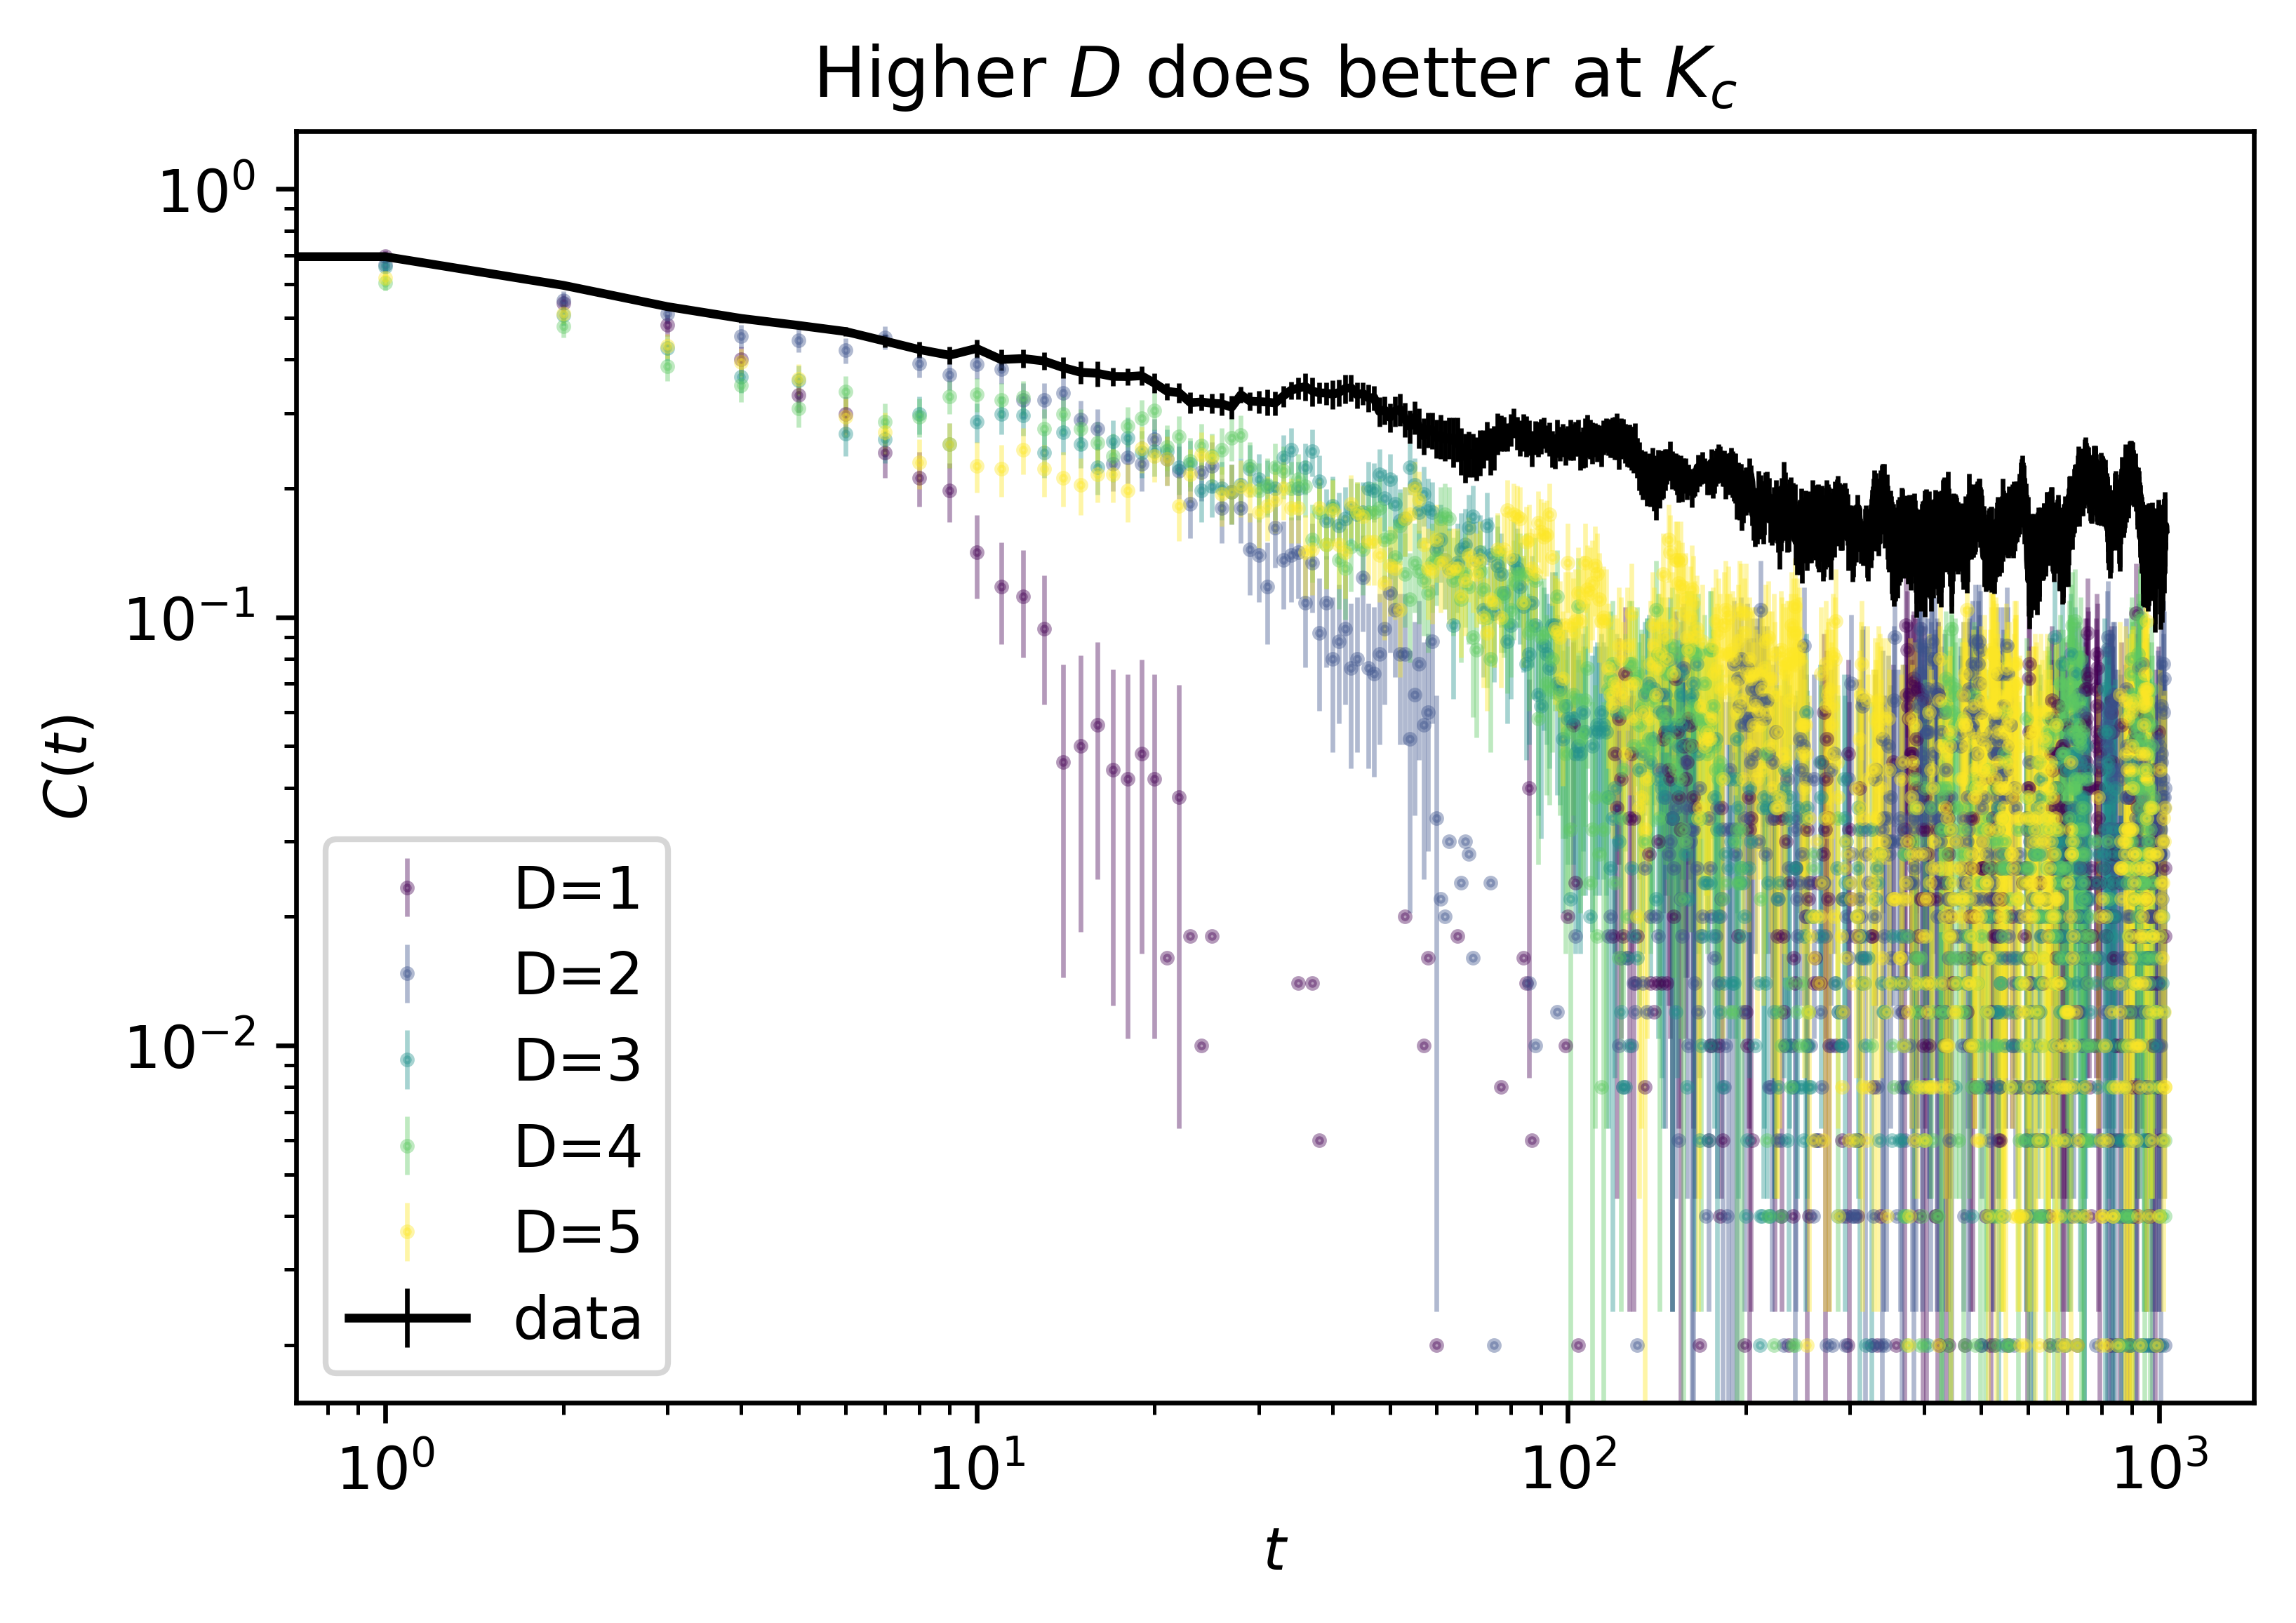

In [33]:
plot_kwargs = {"linestyle":"none", "marker":".", "markersize":3, "alpha":0.4, "elinewidth":0.8}
cmap = mpl.cm.get_cmap(name="viridis", lut=5)
kfrac = 1.0
for hidden_size in np.arange(5)+1:
    with open(f"/Users/jesselin/Dropbox/src/thesis/experiments/2D_ising_processing/corrfunc_comparison/cf_dict_hidden_size={hidden_size}", "rb") as f:
        cf = pickle.load(f)
    rnn_cf, mc_cf = cf[str(kfrac)]
    plt.errorbar(x=np.arange(1024), y=rnn_cf[0][:1024], yerr = rnn_cf[1][:1024], label=f"D={hidden_size}", c=cmap.colors[hidden_size-1], **plot_kwargs)

plt.title(rf"Higher $D$ does better at $K_c$")
plt.errorbar(x=np.arange(1024), y=mc_cf[0][:1024], yerr = mc_cf[1][:1024], label="data", c="k", markersize=3, elinewidth=0.8)
plt.legend()
plt.yscale("log", nonpositive="mask")
plt.xscale("log")
plt.ylabel(r"$C(t)$")
plt.xlabel(r"$t$")
fig = plt.gcf()
fig.set_size_inches(6,4)
fig.set_dpi(300)

In [41]:
m = get_model(1.0, 1, 0)

In [42]:
m.loss_history[-1]

tensor(0.3948)

## Try Entropy estimation

In [22]:
res_dir = "/Users/jesselin/Dropbox/src/thesis/final/resources/2D/compiled extra tensors"
search_term = "compiled_extra*"
file_list = glob.glob(os.path.join(res_dir, search_term))
file_list = sorted(file_list)

In [499]:
file_list[19]

'/Users/jesselin/Dropbox/src/thesis/experiments/rnn_compiled/test_res_dir/compiled tensors/compiled_lattice_tensor_EXP_NUM=8_T=2.339367.pt'

In [501]:
# T = 2.339367
spin_array = torch.load(file_list[19])
spin_array = spin_array.squeeze(-1).numpy()

In [502]:
(1/2.339367)/INTERACTION_Kc

0.9699997111240015

In [503]:
def estimate_entropy(spin_array, num_samples, dataset_size=1000):
    # load dataset
    a = spin_array
    a = a[:dataset_size]

    # maximum entropy dataset
    spin_list = [np.random.choice([1,0]) for x in range(dataset_size)]
    spin_binary = spin_list_to_binary(spin_list)
    with open("maxent.bin", "wb") as f:
        f.write(spin_binary)

    # minimal entropy dataset
    spin_list = [0 for x in range(dataset_size)]
    spin_binary = spin_list_to_binary(spin_list)
    with open("minent.bin", "wb") as f:
        f.write(spin_binary)

    entropy_over_trials = []
    for trial in trange(num_samples):
        rand_index = np.random.randint(0, a.shape[0])
        data = a[rand_index]

        # convert to 1s and 0s
        spin_list = (data+1)/2
        spin_list = spin_list.astype("int").tolist()
        spin_binary = spin_list_to_binary(spin_list)
        with open ("ising.bin", "wb") as f:
            f.write(spin_binary)

        filename_list = ["minent", "maxent", "ising"]
        datasize_list = np.zeros(3)
        for i, name in enumerate(filename_list):
            if os.path.exists(f"{name}.xz"):
                os.remove(f"{name}.xz")
            os.system(f"7z a -txz -mx=9 {name}.xz {name}.bin >/dev/null 2>&1")
            datasize_list[i] = os.path.getsize(f"{name}.xz")
        c0 = datasize_list[0]
        c1 = datasize_list[1]
        cd = datasize_list[2]
        eta = (cd-c0)/(c1-c0)

        entropy_over_trials.append(eta*np.log(2))

    return entropy_over_trials

In [504]:
entropy_estimate_list = estimate_entropy(spin_array, num_samples=10, dataset_size=2048)

100%|██████████| 10/10 [00:00<00:00, 22.95it/s]


In [1]:
np.mean(entropy_estimate_list)

NameError: name 'np' is not defined

# Big $k>1$